# Relation Extraction

## Set variables

In [1]:
logdir = './logs/BiodivBERT' # for tensorboard
MODEL_PATH = 'NoYo25/BiodivBERT'

batch_size = 16
num_train_epochs = 4

Select specific GPU

In [2]:
import os

# os.environ['CUDA_VISIBLE_DEVICES'] = '1'

## Install and import necessary libraries

In [3]:
# ! pip install transformers
# ! pip install pandas
# ! pip install scikit-learn
# ! pip install numpy
# ! pip install torch
# ! pip install optuna
# ! pip install -q tb-nightly
# ! pip install tensorboard
# ! pip install tensorflow

In [4]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import torch
import torchvision
import shutil
import dill

## Dataset Preprocessing


Dataset config file

In [5]:
root_data_dir = "../../Datasets/BiodivRE-MultiClass/"

### GAD Loading

Data loading utils

In [6]:
def loadData(csv_file_path, header=None, index_col=None):
  dataset_path = os.path.join(root_data_dir, csv_file_path)
  data = pd.read_csv(dataset_path, encoding="latin1", sep=',', header=header, index_col=index_col, names=['Label', 'Sentence'])
  return data

In [7]:
def convert_labels_to_integers(df):
    # Define the mapping
    df['Label'] = df['Label'].replace(np.nan, 0)
    df['Label'] = df['Label'].replace('NA', 0)
    label_mapping = {
        'have': 1,
        'occur_in': 2,
        'influence': 3
    }
    
    # Replace the values in the specified column
    df['Label'] = df['Label'].replace(label_mapping)
    df['Label'] = df['Label'].replace(np.nan, 0)
    
    return df

In [8]:
data_train = loadData(csv_file_path='train.csv', header=None, index_col=None)
data_train = convert_labels_to_integers(data_train)

/tmp/ipykernel_6083/3573874737.py:12: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df['Label'] = df['Label'].replace(label_mapping)


In [9]:
data_train.head(10)

,Label,Sentence
0,1,Since our hypotheses are based on growth chara...
1,1,"Commands : as.taxo ( ) , divc ( ) ( div_abgd :..."
2,0,We demonstrate that I. noli- tangere and I. te...
3,0,( ppm ) number # decimal st_dev_p_bicar_ppm da...
4,1,-- - Crown length is calculated as the total t...
5,1,"Commands : as.taxo ( ) , divc ( ) Observed num..."
6,3,Features of @MATTER$ / Chargo al ( depth ) inf...
7,1,Spatiotemporal modulation of biodiversity in a...
8,0,Species were removed in a subtractive fashion ...
9,0,"In 18 grazed and 21 improved fallows , we esti..."


In [10]:
data_test = loadData(csv_file_path='test.csv', header=None, index_col=None)
data_test = convert_labels_to_integers(data_test)

/tmp/ipykernel_6083/3573874737.py:12: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df['Label'] = df['Label'].replace(label_mapping)


In [11]:
data_dev = loadData(csv_file_path='val.csv', header=None, index_col=None)
data_dev = convert_labels_to_integers(data_dev)

/tmp/ipykernel_6083/3573874737.py:12: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df['Label'] = df['Label'].replace(label_mapping)


In [12]:
data_dev.head(10)

,Label,Sentence
0,0,additional trees aluminium cadmium calcium car...
1,0,-- - 6 digit metal tags starting with 3 were a...
2,1,"In a grassland biodiversity experiment , we ad..."
3,1,This is the first comparative study of the @EN...
4,1,This suggests that the @QUALITY$ contributed b...
5,2,( @ORGANISM$ : species ) The scientific specie...
6,2,countries Reading the Complex Skipper Butterfl...
7,0,Revealing the Appetite of the Marine Aquarium ...
8,0,"forest species , open-habitat species , genera..."
9,0,We demonstrate that I. noli- tangere and I. te...


In [13]:
print(len(data_train), len(data_test), len(data_dev))

3200 400 400


split texts and labels

In [14]:
data_train.columns

Index(['Label', 'Sentence'], dtype='object')

In [15]:
train_texts = data_train[data_train.columns[1]].to_list()
train_labels = data_train[data_train.columns[0]].to_list()

In [16]:
test_texts = data_test[data_test.columns[1]].to_list()
test_labels = data_test[data_test.columns[0]].to_list()

In [17]:
dev_texts = data_dev[data_dev.columns[1]].to_list()
dev_labels = data_dev[data_dev.columns[0]].to_list()

Some visualizations useful for max_len determination, BERT in all cases is limited to 512 word input. After running the below cells, some sentenaces exceeded this limit, we will need truncation during the tokenizer step

In [18]:
plt.style.use("ggplot")

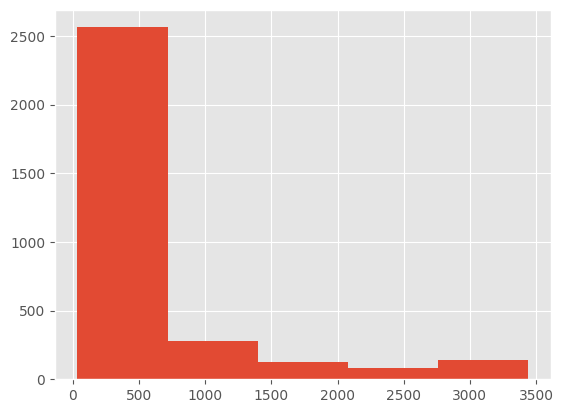

In [19]:
plt.hist([len(s) for s in train_texts], bins=5)
plt.show()

In [20]:
max([len(s) for s in train_texts]) # we will need truncation (automatically on token encodings and manually in the encode_labels function)

3442

In [21]:
max([len(s) for s in test_texts])

3442

In [22]:
max([len(s) for s in dev_texts])

3431

## Explicit Truncation

In [23]:
from transformers import AutoTokenizer

tokenizer = AutoTokenizer.from_pretrained(MODEL_PATH)

In [24]:
train_encodings = tokenizer(train_texts, padding=True, truncation=True, max_length=128)
dev_encodings = tokenizer(dev_texts, padding=True, truncation=True, max_length=128)
test_encodings = tokenizer(test_texts, padding=True, truncation=True, max_length=128)

In [25]:
len(train_encodings[0])

128

### Dataset objects 

Create the dataset objects

In [26]:
class MyDataset(torch.utils.data.Dataset):
    def __init__(self, encodings, labels):
        self.encodings = encodings
        self.labels = labels

    def __getitem__(self, idx):
        item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
        item['labels'] = torch.tensor(self.labels[idx])
        return item

    def __len__(self):
        return len(self.labels)

In [27]:
train_dataset = MyDataset(train_encodings, train_labels)
dev_dataset = MyDataset(dev_encodings, dev_labels)
test_dataset = MyDataset(test_encodings, test_labels)

# Hyperparameter Optimization

## Set-up

Instantiating the model

In [28]:
from transformers import AutoModelForSequenceClassification

def model_init():
    return AutoModelForSequenceClassification.from_pretrained(MODEL_PATH, num_labels=4)

Defining the hyperparameter search space

In [29]:
from optuna import Trial
from typing import Dict, Union

def hp_space(trial: Trial) -> Dict[str, Union[float, int, str]]:
    return {
        "learning_rate": trial.suggest_float("learning_rate", 1e-6, 1e-3, log=True),
        "num_train_epochs": trial.suggest_int("num_train_epochs", 3, 10),
    }

Defining the compute_metrics function

In [30]:
from sklearn.metrics import accuracy_score

def compute_metrics(p):
    predictions, labels = p
    predictions = np.argmax(predictions, axis=1)

    # print(labels)
    # print(predictions)
    # Remove ignored index (special tokens)
    # Create a long 1D list of y_true and y_pred
    y_true = []
    y_pred = []
    for pred, lbl in zip(predictions, labels):  
      y_true.append(lbl) 
      y_pred.append(pred)    
    acc = accuracy_score(y_true, y_pred)
    return {    # we can customize this dictionary to include Pr, Recall and F1-Score as well.
        "accuracy": acc,
    }

Clear model directory if it hasn't been cleared yet.

In [31]:
def delete_dir(directory_path):
    if os.path.exists(directory_path):
        try:
            # Remove the directory
            shutil.rmtree(directory_path)
            print(f"Directory '{directory_path}' removed successfully.")
        except Exception as e:
            print(f"Error removing directory '{directory_path}': {e}")
    else:
        print(f"Directory '{directory_path}' does not exist.")

delete_dir("./results")
delete_dir("./re.model")

Directory './results' removed successfully.
Directory './re.model' removed successfully.


In [32]:
from transformers import TrainerCallback, TrainerState

class CleanupCallback(TrainerCallback):
    def on_train_begin(self, args, state, control, **kwargs):
        shutil.rmtree("./results", ignore_errors=True)
        
        global best_trial_accuracy, best_trial_epoch
        best_trial_accuracy = 0.0
        best_trial_epoch = 0

Defining the training arguments

In [33]:
from transformers import Trainer, TrainingArguments, EarlyStoppingCallback
from transformers.integrations import TensorBoardCallback

training_args = TrainingArguments(
    output_dir='./results',          # output directory
    num_train_epochs=num_train_epochs,              # total number of training epochs
    per_device_train_batch_size=batch_size,  # batch size per device during training
    per_device_eval_batch_size=batch_size,   # batch size for evaluation
    gradient_accumulation_steps=4,
    warmup_steps=500,                # number of warmup steps for learning rate scheduler
    weight_decay=0.01,               # strength of weight decay
    logging_dir=logdir,            # directory for storing logs
    logging_steps=10,
    evaluation_strategy = "steps",
    eval_steps=50,
    save_strategy="steps",
    save_steps=50,
    save_total_limit=2,
    metric_for_best_model="eval_accuracy",
    load_best_model_at_end=True,
    report_to="none"
  )

trainer = Trainer(
    model_init=model_init,                         # the instantiated Transformers model to be trained
    tokenizer=tokenizer,
    args=training_args,                  # training arguments, defined above
    train_dataset=train_dataset,         # training dataset  
    eval_dataset=dev_dataset,           # evaluation dataset
    compute_metrics=compute_metrics,  
    callbacks=[EarlyStoppingCallback(early_stopping_patience=3, early_stopping_threshold=0.001), CleanupCallback()], #CleanupCallback()
)

2024-03-29 20:54:12.102356: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-03-29 20:54:12.188723: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


2024-03-29 20:54:13.851180: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


/home/nlpbiodiv2023/ENTER/lib/python3.12/site-packages/accelerate/accelerator.py:432: FutureWarning: Passing the following arguments to `Accelerator` is deprecated and will be removed in version 1.0 of Accelerate: dict_keys(['dispatch_batches', 'split_batches', 'even_batches', 'use_seedable_sampler']). Please pass an `accelerate.DataLoaderConfiguration` instead: 
dataloader_config = DataLoaderConfiguration(dispatch_batches=None, split_batches=False, even_batches=True, use_seedable_sampler=True)
  warnings.warn(


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at NoYo25/BiodivBERT and are newly initialized: ['bert.pooler.dense.bias', 'bert.pooler.dense.weight', 'classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


## Hyperparameter Search

In [34]:
best_overall_accuracy = 0.0  # Initialize the best accuracy
best_overall_epoch = 0

best_trial_accuracy = 0.0
best_trial_epoch = 0

def compute_objective(metrics):
    global best_overall_accuracy, best_overall_epoch, best_trial_accuracy, best_trial_epoch
    if metrics['eval_accuracy'] > best_trial_accuracy:
        best_trial_accuracy = metrics['eval_accuracy']
        best_trial_epoch = trainer.state.epoch
    if metrics['eval_accuracy'] > best_overall_accuracy:
        best_overall_accuracy = metrics['eval_accuracy']
        best_overall_epoch = trainer.state.epoch
    return best_trial_accuracy

In [35]:
best_run = trainer.hyperparameter_search(
    hp_space=hp_space,
    n_trials=100,
    direction="maximize",
    compute_objective=compute_objective,
)

[I 2024-03-29 20:54:22,492] A new study created in memory with name: no-name-69ca3654-5eeb-4dd2-8b08-0795dd592ab9


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at NoYo25/BiodivBERT and are newly initialized: ['bert.pooler.dense.bias', 'bert.pooler.dense.weight', 'classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Step,Training Loss,Validation Loss,Accuracy
50,0.907700,0.908056,0.685000
100,0.846500,0.807000,0.707500
150,0.668200,0.718779,0.722500
200,0.548100,0.659575,0.742500
250,0.449700,0.679176,0.735000
300,0.371500,0.628838,0.745000
350,0.380900,0.692742,0.742500


[I 2024-03-29 20:59:40,547] Trial 0 finished with value: 0.745 and parameters: {'learning_rate': 6.680977491908919e-05, 'num_train_epochs': 7}. Best is trial 0 with value: 0.745.


/home/nlpbiodiv2023/ENTER/lib/python3.12/site-packages/accelerate/accelerator.py:432: FutureWarning: Passing the following arguments to `Accelerator` is deprecated and will be removed in version 1.0 of Accelerate: dict_keys(['dispatch_batches', 'split_batches', 'even_batches', 'use_seedable_sampler']). Please pass an `accelerate.DataLoaderConfiguration` instead: 
dataloader_config = DataLoaderConfiguration(dispatch_batches=None, split_batches=False, even_batches=True, use_seedable_sampler=True)
  warnings.warn(


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at NoYo25/BiodivBERT and are newly initialized: ['bert.pooler.dense.bias', 'bert.pooler.dense.weight', 'classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Step,Training Loss,Validation Loss,Accuracy
50,1.314900,1.301254,0.655000
100,1.136700,1.086899,0.685000
150,0.932300,0.916432,0.685000
200,0.912300,0.889224,0.685000
250,0.885500,0.865259,0.685000


[I 2024-03-29 21:03:29,537] Trial 1 finished with value: 0.685 and parameters: {'learning_rate': 4.167572963107364e-06, 'num_train_epochs': 5}. Best is trial 0 with value: 0.745.


/home/nlpbiodiv2023/ENTER/lib/python3.12/site-packages/accelerate/accelerator.py:432: FutureWarning: Passing the following arguments to `Accelerator` is deprecated and will be removed in version 1.0 of Accelerate: dict_keys(['dispatch_batches', 'split_batches', 'even_batches', 'use_seedable_sampler']). Please pass an `accelerate.DataLoaderConfiguration` instead: 
dataloader_config = DataLoaderConfiguration(dispatch_batches=None, split_batches=False, even_batches=True, use_seedable_sampler=True)
  warnings.warn(


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at NoYo25/BiodivBERT and are newly initialized: ['bert.pooler.dense.bias', 'bert.pooler.dense.weight', 'classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Step,Training Loss,Validation Loss,Accuracy
50,1.339400,1.331128,0.582500
100,1.242300,1.214799,0.682500
150,1.032700,1.004673,0.685000
200,0.943600,0.915993,0.685000
250,0.921200,0.894208,0.685000
300,0.890100,0.870896,0.685000


[I 2024-03-29 21:08:00,996] Trial 2 finished with value: 0.685 and parameters: {'learning_rate': 2.330496830847051e-06, 'num_train_epochs': 6}. Best is trial 0 with value: 0.745.


/home/nlpbiodiv2023/ENTER/lib/python3.12/site-packages/accelerate/accelerator.py:432: FutureWarning: Passing the following arguments to `Accelerator` is deprecated and will be removed in version 1.0 of Accelerate: dict_keys(['dispatch_batches', 'split_batches', 'even_batches', 'use_seedable_sampler']). Please pass an `accelerate.DataLoaderConfiguration` instead: 
dataloader_config = DataLoaderConfiguration(dispatch_batches=None, split_batches=False, even_batches=True, use_seedable_sampler=True)
  warnings.warn(


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at NoYo25/BiodivBERT and are newly initialized: ['bert.pooler.dense.bias', 'bert.pooler.dense.weight', 'classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Step,Training Loss,Validation Loss,Accuracy
50,1.357200,1.352898,0.475000
100,1.316600,1.300953,0.655000
150,1.225600,1.213557,0.682500
200,1.109700,1.080998,0.685000
250,0.980000,0.943912,0.685000
300,0.936500,0.911906,0.685000
350,0.941500,0.897238,0.685000


[I 2024-03-29 21:13:17,628] Trial 3 finished with value: 0.685 and parameters: {'learning_rate': 1.0272757527782514e-06, 'num_train_epochs': 9}. Best is trial 0 with value: 0.745.


/home/nlpbiodiv2023/ENTER/lib/python3.12/site-packages/accelerate/accelerator.py:432: FutureWarning: Passing the following arguments to `Accelerator` is deprecated and will be removed in version 1.0 of Accelerate: dict_keys(['dispatch_batches', 'split_batches', 'even_batches', 'use_seedable_sampler']). Please pass an `accelerate.DataLoaderConfiguration` instead: 
dataloader_config = DataLoaderConfiguration(dispatch_batches=None, split_batches=False, even_batches=True, use_seedable_sampler=True)
  warnings.warn(


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at NoYo25/BiodivBERT and are newly initialized: ['bert.pooler.dense.bias', 'bert.pooler.dense.weight', 'classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Step,Training Loss,Validation Loss,Accuracy
50,1.158600,1.109281,0.685000
100,0.950900,0.895639,0.685000
150,0.853600,0.847523,0.687500
200,0.767000,0.798316,0.697500
250,0.700900,0.733716,0.717500
300,0.612500,0.686300,0.727500
350,0.569800,0.708492,0.710000


[I 2024-03-29 21:18:34,030] Trial 4 finished with value: 0.7275 and parameters: {'learning_rate': 1.6088725696960938e-05, 'num_train_epochs': 7}. Best is trial 0 with value: 0.745.


/home/nlpbiodiv2023/ENTER/lib/python3.12/site-packages/accelerate/accelerator.py:432: FutureWarning: Passing the following arguments to `Accelerator` is deprecated and will be removed in version 1.0 of Accelerate: dict_keys(['dispatch_batches', 'split_batches', 'even_batches', 'use_seedable_sampler']). Please pass an `accelerate.DataLoaderConfiguration` instead: 
dataloader_config = DataLoaderConfiguration(dispatch_batches=None, split_batches=False, even_batches=True, use_seedable_sampler=True)
  warnings.warn(


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at NoYo25/BiodivBERT and are newly initialized: ['bert.pooler.dense.bias', 'bert.pooler.dense.weight', 'classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Step,Training Loss,Validation Loss,Accuracy
50,1.105400,1.044289,0.685000
100,0.937700,0.884089,0.685000
150,0.827700,0.829911,0.705000
200,0.726800,0.787862,0.685000
250,0.638200,0.713871,0.717500
300,0.563400,0.673212,0.722500
350,0.520700,0.668083,0.740000


[I 2024-03-29 21:23:51,144] Trial 5 finished with value: 0.74 and parameters: {'learning_rate': 2.010876490359696e-05, 'num_train_epochs': 7}. Best is trial 0 with value: 0.745.


/home/nlpbiodiv2023/ENTER/lib/python3.12/site-packages/accelerate/accelerator.py:432: FutureWarning: Passing the following arguments to `Accelerator` is deprecated and will be removed in version 1.0 of Accelerate: dict_keys(['dispatch_batches', 'split_batches', 'even_batches', 'use_seedable_sampler']). Please pass an `accelerate.DataLoaderConfiguration` instead: 
dataloader_config = DataLoaderConfiguration(dispatch_batches=None, split_batches=False, even_batches=True, use_seedable_sampler=True)
  warnings.warn(


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at NoYo25/BiodivBERT and are newly initialized: ['bert.pooler.dense.bias', 'bert.pooler.dense.weight', 'classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Step,Training Loss,Validation Loss,Accuracy
50,0.905500,0.892844,0.685000
100,0.826500,0.769226,0.710000
150,0.650900,0.703858,0.722500


[I 2024-03-29 21:26:08,794] Trial 6 finished with value: 0.7225 and parameters: {'learning_rate': 9.389305402683459e-05, 'num_train_epochs': 3}. Best is trial 0 with value: 0.745.


/home/nlpbiodiv2023/ENTER/lib/python3.12/site-packages/accelerate/accelerator.py:432: FutureWarning: Passing the following arguments to `Accelerator` is deprecated and will be removed in version 1.0 of Accelerate: dict_keys(['dispatch_batches', 'split_batches', 'even_batches', 'use_seedable_sampler']). Please pass an `accelerate.DataLoaderConfiguration` instead: 
dataloader_config = DataLoaderConfiguration(dispatch_batches=None, split_batches=False, even_batches=True, use_seedable_sampler=True)
  warnings.warn(


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at NoYo25/BiodivBERT and are newly initialized: ['bert.pooler.dense.bias', 'bert.pooler.dense.weight', 'classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Step,Training Loss,Validation Loss,Accuracy
50,0.895200,0.881060,0.685000
100,0.793600,0.703500,0.727500
150,0.596900,0.718373,0.732500
200,0.495800,0.682299,0.737500


[I 2024-03-29 21:29:11,239] Trial 7 finished with value: 0.7375 and parameters: {'learning_rate': 0.00014427963962293172, 'num_train_epochs': 4}. Best is trial 0 with value: 0.745.


/home/nlpbiodiv2023/ENTER/lib/python3.12/site-packages/accelerate/accelerator.py:432: FutureWarning: Passing the following arguments to `Accelerator` is deprecated and will be removed in version 1.0 of Accelerate: dict_keys(['dispatch_batches', 'split_batches', 'even_batches', 'use_seedable_sampler']). Please pass an `accelerate.DataLoaderConfiguration` instead: 
dataloader_config = DataLoaderConfiguration(dispatch_batches=None, split_batches=False, even_batches=True, use_seedable_sampler=True)
  warnings.warn(


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at NoYo25/BiodivBERT and are newly initialized: ['bert.pooler.dense.bias', 'bert.pooler.dense.weight', 'classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Step,Training Loss,Validation Loss,Accuracy
50,1.198800,1.158311,0.685000
100,0.960200,0.903765,0.685000
150,0.870700,0.859856,0.685000


[I 2024-03-29 21:31:25,906] Trial 8 pruned. 


/home/nlpbiodiv2023/ENTER/lib/python3.12/site-packages/accelerate/accelerator.py:432: FutureWarning: Passing the following arguments to `Accelerator` is deprecated and will be removed in version 1.0 of Accelerate: dict_keys(['dispatch_batches', 'split_batches', 'even_batches', 'use_seedable_sampler']). Please pass an `accelerate.DataLoaderConfiguration` instead: 
dataloader_config = DataLoaderConfiguration(dispatch_batches=None, split_batches=False, even_batches=True, use_seedable_sampler=True)
  warnings.warn(


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at NoYo25/BiodivBERT and are newly initialized: ['bert.pooler.dense.bias', 'bert.pooler.dense.weight', 'classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Step,Training Loss,Validation Loss,Accuracy
50,0.835400,0.795478,0.705000
100,0.724700,0.818008,0.682500
150,0.564500,0.683559,0.697500
200,0.639900,0.834821,0.575000


[I 2024-03-29 21:34:28,232] Trial 9 finished with value: 0.705 and parameters: {'learning_rate': 0.0007988805109892494, 'num_train_epochs': 4}. Best is trial 0 with value: 0.745.


/home/nlpbiodiv2023/ENTER/lib/python3.12/site-packages/accelerate/accelerator.py:432: FutureWarning: Passing the following arguments to `Accelerator` is deprecated and will be removed in version 1.0 of Accelerate: dict_keys(['dispatch_batches', 'split_batches', 'even_batches', 'use_seedable_sampler']). Please pass an `accelerate.DataLoaderConfiguration` instead: 
dataloader_config = DataLoaderConfiguration(dispatch_batches=None, split_batches=False, even_batches=True, use_seedable_sampler=True)
  warnings.warn(


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at NoYo25/BiodivBERT and are newly initialized: ['bert.pooler.dense.bias', 'bert.pooler.dense.weight', 'classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Step,Training Loss,Validation Loss,Accuracy
50,0.848800,0.841147,0.685000
100,0.694400,0.775215,0.697500
150,0.572800,0.668837,0.732500
200,0.686500,0.716362,0.707500
250,0.724400,0.796977,0.685000
300,0.730700,0.844739,0.682500


[I 2024-03-29 21:39:00,780] Trial 10 finished with value: 0.7325 and parameters: {'learning_rate': 0.0009073821269565093, 'num_train_epochs': 8}. Best is trial 0 with value: 0.745.


/home/nlpbiodiv2023/ENTER/lib/python3.12/site-packages/accelerate/accelerator.py:432: FutureWarning: Passing the following arguments to `Accelerator` is deprecated and will be removed in version 1.0 of Accelerate: dict_keys(['dispatch_batches', 'split_batches', 'even_batches', 'use_seedable_sampler']). Please pass an `accelerate.DataLoaderConfiguration` instead: 
dataloader_config = DataLoaderConfiguration(dispatch_batches=None, split_batches=False, even_batches=True, use_seedable_sampler=True)
  warnings.warn(


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at NoYo25/BiodivBERT and are newly initialized: ['bert.pooler.dense.bias', 'bert.pooler.dense.weight', 'classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Step,Training Loss,Validation Loss,Accuracy
50,0.907600,0.911362,0.685000
100,0.854500,0.812205,0.702500
150,0.675000,0.705405,0.735000
200,0.547000,0.656006,0.732500
250,0.455600,0.682539,0.730000
300,0.379600,0.633957,0.732500


[I 2024-03-29 21:43:32,858] Trial 11 finished with value: 0.735 and parameters: {'learning_rate': 6.358284948030888e-05, 'num_train_epochs': 7}. Best is trial 0 with value: 0.745.


/home/nlpbiodiv2023/ENTER/lib/python3.12/site-packages/accelerate/accelerator.py:432: FutureWarning: Passing the following arguments to `Accelerator` is deprecated and will be removed in version 1.0 of Accelerate: dict_keys(['dispatch_batches', 'split_batches', 'even_batches', 'use_seedable_sampler']). Please pass an `accelerate.DataLoaderConfiguration` instead: 
dataloader_config = DataLoaderConfiguration(dispatch_batches=None, split_batches=False, even_batches=True, use_seedable_sampler=True)
  warnings.warn(


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at NoYo25/BiodivBERT and are newly initialized: ['bert.pooler.dense.bias', 'bert.pooler.dense.weight', 'classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Step,Training Loss,Validation Loss,Accuracy
50,1.003300,0.947902,0.685000
100,0.920000,0.867612,0.685000


[I 2024-03-29 21:45:04,346] Trial 12 pruned. 


/home/nlpbiodiv2023/ENTER/lib/python3.12/site-packages/accelerate/accelerator.py:432: FutureWarning: Passing the following arguments to `Accelerator` is deprecated and will be removed in version 1.0 of Accelerate: dict_keys(['dispatch_batches', 'split_batches', 'even_batches', 'use_seedable_sampler']). Please pass an `accelerate.DataLoaderConfiguration` instead: 
dataloader_config = DataLoaderConfiguration(dispatch_batches=None, split_batches=False, even_batches=True, use_seedable_sampler=True)
  warnings.warn(


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at NoYo25/BiodivBERT and are newly initialized: ['bert.pooler.dense.bias', 'bert.pooler.dense.weight', 'classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Step,Training Loss,Validation Loss,Accuracy
50,0.864900,0.856623,0.685000
100,0.782800,0.761300,0.697500
150,0.605900,0.735421,0.687500


[I 2024-03-29 21:47:18,719] Trial 13 pruned. 


/home/nlpbiodiv2023/ENTER/lib/python3.12/site-packages/accelerate/accelerator.py:432: FutureWarning: Passing the following arguments to `Accelerator` is deprecated and will be removed in version 1.0 of Accelerate: dict_keys(['dispatch_batches', 'split_batches', 'even_batches', 'use_seedable_sampler']). Please pass an `accelerate.DataLoaderConfiguration` instead: 
dataloader_config = DataLoaderConfiguration(dispatch_batches=None, split_batches=False, even_batches=True, use_seedable_sampler=True)
  warnings.warn(


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at NoYo25/BiodivBERT and are newly initialized: ['bert.pooler.dense.bias', 'bert.pooler.dense.weight', 'classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Step,Training Loss,Validation Loss,Accuracy
50,1.224600,1.190361,0.685000
100,0.966700,0.912538,0.685000


[I 2024-03-29 21:48:48,712] Trial 14 pruned. 


/home/nlpbiodiv2023/ENTER/lib/python3.12/site-packages/accelerate/accelerator.py:432: FutureWarning: Passing the following arguments to `Accelerator` is deprecated and will be removed in version 1.0 of Accelerate: dict_keys(['dispatch_batches', 'split_batches', 'even_batches', 'use_seedable_sampler']). Please pass an `accelerate.DataLoaderConfiguration` instead: 
dataloader_config = DataLoaderConfiguration(dispatch_batches=None, split_batches=False, even_batches=True, use_seedable_sampler=True)
  warnings.warn(


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at NoYo25/BiodivBERT and are newly initialized: ['bert.pooler.dense.bias', 'bert.pooler.dense.weight', 'classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Step,Training Loss,Validation Loss,Accuracy
50,0.920800,0.927443,0.685000
100,0.885800,0.842368,0.702500
150,0.714000,0.749059,0.715000
200,0.576000,0.687424,0.712500
250,0.496200,0.643746,0.750000
300,0.438200,0.623300,0.752500
350,0.407900,0.618473,0.765000
400,0.319400,0.676718,0.777500
450,0.287800,0.692863,0.760000
500,0.278700,0.810184,0.745000


[I 2024-03-29 21:56:18,668] Trial 15 finished with value: 0.7775 and parameters: {'learning_rate': 4.486787310774406e-05, 'num_train_epochs': 10}. Best is trial 15 with value: 0.7775.


/home/nlpbiodiv2023/ENTER/lib/python3.12/site-packages/accelerate/accelerator.py:432: FutureWarning: Passing the following arguments to `Accelerator` is deprecated and will be removed in version 1.0 of Accelerate: dict_keys(['dispatch_batches', 'split_batches', 'even_batches', 'use_seedable_sampler']). Please pass an `accelerate.DataLoaderConfiguration` instead: 
dataloader_config = DataLoaderConfiguration(dispatch_batches=None, split_batches=False, even_batches=True, use_seedable_sampler=True)
  warnings.warn(


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at NoYo25/BiodivBERT and are newly initialized: ['bert.pooler.dense.bias', 'bert.pooler.dense.weight', 'classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Step,Training Loss,Validation Loss,Accuracy
50,0.850200,0.855451,0.690000
100,0.722000,0.672464,0.735000
150,0.603900,0.765518,0.740000
200,0.496000,0.668834,0.745000
250,0.495700,0.744213,0.750000
300,0.414000,0.601389,0.775000
350,0.361800,0.782084,0.732500
400,0.386200,0.712458,0.772500


[I 2024-03-29 22:02:17,986] Trial 16 pruned. 


/home/nlpbiodiv2023/ENTER/lib/python3.12/site-packages/accelerate/accelerator.py:432: FutureWarning: Passing the following arguments to `Accelerator` is deprecated and will be removed in version 1.0 of Accelerate: dict_keys(['dispatch_batches', 'split_batches', 'even_batches', 'use_seedable_sampler']). Please pass an `accelerate.DataLoaderConfiguration` instead: 
dataloader_config = DataLoaderConfiguration(dispatch_batches=None, split_batches=False, even_batches=True, use_seedable_sampler=True)
  warnings.warn(


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at NoYo25/BiodivBERT and are newly initialized: ['bert.pooler.dense.bias', 'bert.pooler.dense.weight', 'classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Step,Training Loss,Validation Loss,Accuracy
50,0.915900,0.927541,0.685000
100,0.883600,0.841104,0.702500
150,0.717100,0.752159,0.715000
200,0.572800,0.688870,0.717500
250,0.490000,0.649939,0.732500
300,0.425000,0.602702,0.760000
350,0.404700,0.614036,0.762500
400,0.319500,0.693363,0.772500


[I 2024-03-29 22:08:17,616] Trial 17 pruned. 


/home/nlpbiodiv2023/ENTER/lib/python3.12/site-packages/accelerate/accelerator.py:432: FutureWarning: Passing the following arguments to `Accelerator` is deprecated and will be removed in version 1.0 of Accelerate: dict_keys(['dispatch_batches', 'split_batches', 'even_batches', 'use_seedable_sampler']). Please pass an `accelerate.DataLoaderConfiguration` instead: 
dataloader_config = DataLoaderConfiguration(dispatch_batches=None, split_batches=False, even_batches=True, use_seedable_sampler=True)
  warnings.warn(


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at NoYo25/BiodivBERT and are newly initialized: ['bert.pooler.dense.bias', 'bert.pooler.dense.weight', 'classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Step,Training Loss,Validation Loss,Accuracy
50,1.285300,1.265359,0.680000


[I 2024-03-29 22:09:03,870] Trial 18 pruned. 


/home/nlpbiodiv2023/ENTER/lib/python3.12/site-packages/accelerate/accelerator.py:432: FutureWarning: Passing the following arguments to `Accelerator` is deprecated and will be removed in version 1.0 of Accelerate: dict_keys(['dispatch_batches', 'split_batches', 'even_batches', 'use_seedable_sampler']). Please pass an `accelerate.DataLoaderConfiguration` instead: 
dataloader_config = DataLoaderConfiguration(dispatch_batches=None, split_batches=False, even_batches=True, use_seedable_sampler=True)
  warnings.warn(


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at NoYo25/BiodivBERT and are newly initialized: ['bert.pooler.dense.bias', 'bert.pooler.dense.weight', 'classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Step,Training Loss,Validation Loss,Accuracy
50,0.862800,0.859561,0.685000
100,0.759400,0.708791,0.717500
150,0.602100,0.805374,0.730000
200,0.534000,0.602228,0.765000
250,0.451800,0.670809,0.772500


[I 2024-03-29 22:12:50,238] Trial 19 finished with value: 0.7725 and parameters: {'learning_rate': 0.00021485562268514505, 'num_train_epochs': 5}. Best is trial 15 with value: 0.7775.


/home/nlpbiodiv2023/ENTER/lib/python3.12/site-packages/accelerate/accelerator.py:432: FutureWarning: Passing the following arguments to `Accelerator` is deprecated and will be removed in version 1.0 of Accelerate: dict_keys(['dispatch_batches', 'split_batches', 'even_batches', 'use_seedable_sampler']). Please pass an `accelerate.DataLoaderConfiguration` instead: 
dataloader_config = DataLoaderConfiguration(dispatch_batches=None, split_batches=False, even_batches=True, use_seedable_sampler=True)
  warnings.warn(


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at NoYo25/BiodivBERT and are newly initialized: ['bert.pooler.dense.bias', 'bert.pooler.dense.weight', 'classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Step,Training Loss,Validation Loss,Accuracy
50,0.844400,0.844625,0.710000
100,0.726700,0.656267,0.737500
150,0.588400,0.778106,0.740000
200,0.476200,0.655051,0.735000
250,0.483500,0.754520,0.745000


[I 2024-03-29 22:16:36,830] Trial 20 finished with value: 0.745 and parameters: {'learning_rate': 0.0003414584683419645, 'num_train_epochs': 5}. Best is trial 15 with value: 0.7775.


/home/nlpbiodiv2023/ENTER/lib/python3.12/site-packages/accelerate/accelerator.py:432: FutureWarning: Passing the following arguments to `Accelerator` is deprecated and will be removed in version 1.0 of Accelerate: dict_keys(['dispatch_batches', 'split_batches', 'even_batches', 'use_seedable_sampler']). Please pass an `accelerate.DataLoaderConfiguration` instead: 
dataloader_config = DataLoaderConfiguration(dispatch_batches=None, split_batches=False, even_batches=True, use_seedable_sampler=True)
  warnings.warn(


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at NoYo25/BiodivBERT and are newly initialized: ['bert.pooler.dense.bias', 'bert.pooler.dense.weight', 'classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Step,Training Loss,Validation Loss,Accuracy
50,0.899000,0.882955,0.685000
100,0.802000,0.720167,0.725000
150,0.595200,0.715661,0.732500
200,0.482100,0.649714,0.745000
250,0.420500,0.688560,0.762500


[I 2024-03-29 22:20:24,871] Trial 21 finished with value: 0.7625 and parameters: {'learning_rate': 0.0001325728049714885, 'num_train_epochs': 5}. Best is trial 15 with value: 0.7775.


/home/nlpbiodiv2023/ENTER/lib/python3.12/site-packages/accelerate/accelerator.py:432: FutureWarning: Passing the following arguments to `Accelerator` is deprecated and will be removed in version 1.0 of Accelerate: dict_keys(['dispatch_batches', 'split_batches', 'even_batches', 'use_seedable_sampler']). Please pass an `accelerate.DataLoaderConfiguration` instead: 
dataloader_config = DataLoaderConfiguration(dispatch_batches=None, split_batches=False, even_batches=True, use_seedable_sampler=True)
  warnings.warn(


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at NoYo25/BiodivBERT and are newly initialized: ['bert.pooler.dense.bias', 'bert.pooler.dense.weight', 'classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Step,Training Loss,Validation Loss,Accuracy
50,0.888800,0.878820,0.685000
100,0.809300,0.742890,0.710000
150,0.571200,0.675178,0.742500
200,0.517600,0.602956,0.755000
250,0.414300,0.627653,0.757500


[I 2024-03-29 22:24:11,598] Trial 22 finished with value: 0.7575 and parameters: {'learning_rate': 0.00015781434585089164, 'num_train_epochs': 5}. Best is trial 15 with value: 0.7775.


/home/nlpbiodiv2023/ENTER/lib/python3.12/site-packages/accelerate/accelerator.py:432: FutureWarning: Passing the following arguments to `Accelerator` is deprecated and will be removed in version 1.0 of Accelerate: dict_keys(['dispatch_batches', 'split_batches', 'even_batches', 'use_seedable_sampler']). Please pass an `accelerate.DataLoaderConfiguration` instead: 
dataloader_config = DataLoaderConfiguration(dispatch_batches=None, split_batches=False, even_batches=True, use_seedable_sampler=True)
  warnings.warn(


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at NoYo25/BiodivBERT and are newly initialized: ['bert.pooler.dense.bias', 'bert.pooler.dense.weight', 'classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Step,Training Loss,Validation Loss,Accuracy
50,0.904900,0.885458,0.685000
100,0.810300,0.741572,0.712500
150,0.601000,0.698199,0.727500
200,0.511500,0.655995,0.740000


[I 2024-03-29 22:27:13,897] Trial 23 finished with value: 0.74 and parameters: {'learning_rate': 0.00012062914868991261, 'num_train_epochs': 4}. Best is trial 15 with value: 0.7775.


/home/nlpbiodiv2023/ENTER/lib/python3.12/site-packages/accelerate/accelerator.py:432: FutureWarning: Passing the following arguments to `Accelerator` is deprecated and will be removed in version 1.0 of Accelerate: dict_keys(['dispatch_batches', 'split_batches', 'even_batches', 'use_seedable_sampler']). Please pass an `accelerate.DataLoaderConfiguration` instead: 
dataloader_config = DataLoaderConfiguration(dispatch_batches=None, split_batches=False, even_batches=True, use_seedable_sampler=True)
  warnings.warn(


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at NoYo25/BiodivBERT and are newly initialized: ['bert.pooler.dense.bias', 'bert.pooler.dense.weight', 'classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Step,Training Loss,Validation Loss,Accuracy
50,0.880200,0.838984,0.685000
100,0.697900,0.635323,0.740000
150,0.554300,0.706502,0.710000


[I 2024-03-29 22:29:30,647] Trial 24 finished with value: 0.74 and parameters: {'learning_rate': 0.0005403160548891543, 'num_train_epochs': 3}. Best is trial 15 with value: 0.7775.


/home/nlpbiodiv2023/ENTER/lib/python3.12/site-packages/accelerate/accelerator.py:432: FutureWarning: Passing the following arguments to `Accelerator` is deprecated and will be removed in version 1.0 of Accelerate: dict_keys(['dispatch_batches', 'split_batches', 'even_batches', 'use_seedable_sampler']). Please pass an `accelerate.DataLoaderConfiguration` instead: 
dataloader_config = DataLoaderConfiguration(dispatch_batches=None, split_batches=False, even_batches=True, use_seedable_sampler=True)
  warnings.warn(


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at NoYo25/BiodivBERT and are newly initialized: ['bert.pooler.dense.bias', 'bert.pooler.dense.weight', 'classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Step,Training Loss,Validation Loss,Accuracy
50,0.920200,0.925912,0.685000
100,0.885200,0.840372,0.702500


[I 2024-03-29 22:31:00,877] Trial 25 pruned. 


/home/nlpbiodiv2023/ENTER/lib/python3.12/site-packages/accelerate/accelerator.py:432: FutureWarning: Passing the following arguments to `Accelerator` is deprecated and will be removed in version 1.0 of Accelerate: dict_keys(['dispatch_batches', 'split_batches', 'even_batches', 'use_seedable_sampler']). Please pass an `accelerate.DataLoaderConfiguration` instead: 
dataloader_config = DataLoaderConfiguration(dispatch_batches=None, split_batches=False, even_batches=True, use_seedable_sampler=True)
  warnings.warn(


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at NoYo25/BiodivBERT and are newly initialized: ['bert.pooler.dense.bias', 'bert.pooler.dense.weight', 'classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Step,Training Loss,Validation Loss,Accuracy
50,0.871000,0.868616,0.685000
100,0.781600,0.693484,0.725000
150,0.609500,0.721024,0.737500
200,0.489000,0.650449,0.735000
250,0.435800,0.633169,0.762500


[I 2024-03-29 22:34:47,578] Trial 26 finished with value: 0.7625 and parameters: {'learning_rate': 0.00019259789764897728, 'num_train_epochs': 5}. Best is trial 15 with value: 0.7775.


/home/nlpbiodiv2023/ENTER/lib/python3.12/site-packages/accelerate/accelerator.py:432: FutureWarning: Passing the following arguments to `Accelerator` is deprecated and will be removed in version 1.0 of Accelerate: dict_keys(['dispatch_batches', 'split_batches', 'even_batches', 'use_seedable_sampler']). Please pass an `accelerate.DataLoaderConfiguration` instead: 
dataloader_config = DataLoaderConfiguration(dispatch_batches=None, split_batches=False, even_batches=True, use_seedable_sampler=True)
  warnings.warn(


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at NoYo25/BiodivBERT and are newly initialized: ['bert.pooler.dense.bias', 'bert.pooler.dense.weight', 'classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Step,Training Loss,Validation Loss,Accuracy
50,0.842500,0.848857,0.707500
100,0.712100,0.672919,0.715000
150,0.584900,0.747836,0.692500


[I 2024-03-29 22:37:02,281] Trial 27 pruned. 


/home/nlpbiodiv2023/ENTER/lib/python3.12/site-packages/accelerate/accelerator.py:432: FutureWarning: Passing the following arguments to `Accelerator` is deprecated and will be removed in version 1.0 of Accelerate: dict_keys(['dispatch_batches', 'split_batches', 'even_batches', 'use_seedable_sampler']). Please pass an `accelerate.DataLoaderConfiguration` instead: 
dataloader_config = DataLoaderConfiguration(dispatch_batches=None, split_batches=False, even_batches=True, use_seedable_sampler=True)
  warnings.warn(


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at NoYo25/BiodivBERT and are newly initialized: ['bert.pooler.dense.bias', 'bert.pooler.dense.weight', 'classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Step,Training Loss,Validation Loss,Accuracy
50,0.906300,0.896157,0.685000
100,0.831600,0.778472,0.707500
150,0.645500,0.710128,0.720000


[I 2024-03-29 22:39:17,904] Trial 28 pruned. 


/home/nlpbiodiv2023/ENTER/lib/python3.12/site-packages/accelerate/accelerator.py:432: FutureWarning: Passing the following arguments to `Accelerator` is deprecated and will be removed in version 1.0 of Accelerate: dict_keys(['dispatch_batches', 'split_batches', 'even_batches', 'use_seedable_sampler']). Please pass an `accelerate.DataLoaderConfiguration` instead: 
dataloader_config = DataLoaderConfiguration(dispatch_batches=None, split_batches=False, even_batches=True, use_seedable_sampler=True)
  warnings.warn(


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at NoYo25/BiodivBERT and are newly initialized: ['bert.pooler.dense.bias', 'bert.pooler.dense.weight', 'classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Step,Training Loss,Validation Loss,Accuracy
50,0.998200,0.944815,0.685000
100,0.919300,0.867775,0.685000


[I 2024-03-29 22:40:48,296] Trial 29 pruned. 


/home/nlpbiodiv2023/ENTER/lib/python3.12/site-packages/accelerate/accelerator.py:432: FutureWarning: Passing the following arguments to `Accelerator` is deprecated and will be removed in version 1.0 of Accelerate: dict_keys(['dispatch_batches', 'split_batches', 'even_batches', 'use_seedable_sampler']). Please pass an `accelerate.DataLoaderConfiguration` instead: 
dataloader_config = DataLoaderConfiguration(dispatch_batches=None, split_batches=False, even_batches=True, use_seedable_sampler=True)
  warnings.warn(


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at NoYo25/BiodivBERT and are newly initialized: ['bert.pooler.dense.bias', 'bert.pooler.dense.weight', 'classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Step,Training Loss,Validation Loss,Accuracy
50,0.908100,0.914371,0.685000
100,0.854600,0.812701,0.702500


[I 2024-03-29 22:42:18,321] Trial 30 pruned. 


/home/nlpbiodiv2023/ENTER/lib/python3.12/site-packages/accelerate/accelerator.py:432: FutureWarning: Passing the following arguments to `Accelerator` is deprecated and will be removed in version 1.0 of Accelerate: dict_keys(['dispatch_batches', 'split_batches', 'even_batches', 'use_seedable_sampler']). Please pass an `accelerate.DataLoaderConfiguration` instead: 
dataloader_config = DataLoaderConfiguration(dispatch_batches=None, split_batches=False, even_batches=True, use_seedable_sampler=True)
  warnings.warn(


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at NoYo25/BiodivBERT and are newly initialized: ['bert.pooler.dense.bias', 'bert.pooler.dense.weight', 'classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Step,Training Loss,Validation Loss,Accuracy
50,0.874600,0.871856,0.685000
100,0.782000,0.689223,0.720000
150,0.593000,0.731274,0.732500
200,0.478800,0.629641,0.755000
250,0.429000,0.649938,0.760000


[I 2024-03-29 22:46:04,830] Trial 31 finished with value: 0.76 and parameters: {'learning_rate': 0.00018408916717006028, 'num_train_epochs': 5}. Best is trial 15 with value: 0.7775.


/home/nlpbiodiv2023/ENTER/lib/python3.12/site-packages/accelerate/accelerator.py:432: FutureWarning: Passing the following arguments to `Accelerator` is deprecated and will be removed in version 1.0 of Accelerate: dict_keys(['dispatch_batches', 'split_batches', 'even_batches', 'use_seedable_sampler']). Please pass an `accelerate.DataLoaderConfiguration` instead: 
dataloader_config = DataLoaderConfiguration(dispatch_batches=None, split_batches=False, even_batches=True, use_seedable_sampler=True)
  warnings.warn(


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at NoYo25/BiodivBERT and are newly initialized: ['bert.pooler.dense.bias', 'bert.pooler.dense.weight', 'classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Step,Training Loss,Validation Loss,Accuracy
50,0.862500,0.864701,0.685000
100,0.767900,0.720198,0.720000
150,0.633500,0.732519,0.730000
200,0.515200,0.593663,0.750000
250,0.474000,0.659364,0.750000


[I 2024-03-29 22:49:52,199] Trial 32 finished with value: 0.75 and parameters: {'learning_rate': 0.00022430308607144603, 'num_train_epochs': 5}. Best is trial 15 with value: 0.7775.


/home/nlpbiodiv2023/ENTER/lib/python3.12/site-packages/accelerate/accelerator.py:432: FutureWarning: Passing the following arguments to `Accelerator` is deprecated and will be removed in version 1.0 of Accelerate: dict_keys(['dispatch_batches', 'split_batches', 'even_batches', 'use_seedable_sampler']). Please pass an `accelerate.DataLoaderConfiguration` instead: 
dataloader_config = DataLoaderConfiguration(dispatch_batches=None, split_batches=False, even_batches=True, use_seedable_sampler=True)
  warnings.warn(


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at NoYo25/BiodivBERT and are newly initialized: ['bert.pooler.dense.bias', 'bert.pooler.dense.weight', 'classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Step,Training Loss,Validation Loss,Accuracy
50,0.903100,0.887670,0.685000
100,0.815800,0.752439,0.712500
150,0.653100,0.696425,0.725000


[I 2024-03-29 22:52:06,783] Trial 33 pruned. 


/home/nlpbiodiv2023/ENTER/lib/python3.12/site-packages/accelerate/accelerator.py:432: FutureWarning: Passing the following arguments to `Accelerator` is deprecated and will be removed in version 1.0 of Accelerate: dict_keys(['dispatch_batches', 'split_batches', 'even_batches', 'use_seedable_sampler']). Please pass an `accelerate.DataLoaderConfiguration` instead: 
dataloader_config = DataLoaderConfiguration(dispatch_batches=None, split_batches=False, even_batches=True, use_seedable_sampler=True)
  warnings.warn(


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at NoYo25/BiodivBERT and are newly initialized: ['bert.pooler.dense.bias', 'bert.pooler.dense.weight', 'classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Step,Training Loss,Validation Loss,Accuracy
50,0.833000,0.846094,0.680000


[I 2024-03-29 22:52:52,461] Trial 34 pruned. 


/home/nlpbiodiv2023/ENTER/lib/python3.12/site-packages/accelerate/accelerator.py:432: FutureWarning: Passing the following arguments to `Accelerator` is deprecated and will be removed in version 1.0 of Accelerate: dict_keys(['dispatch_batches', 'split_batches', 'even_batches', 'use_seedable_sampler']). Please pass an `accelerate.DataLoaderConfiguration` instead: 
dataloader_config = DataLoaderConfiguration(dispatch_batches=None, split_batches=False, even_batches=True, use_seedable_sampler=True)
  warnings.warn(


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at NoYo25/BiodivBERT and are newly initialized: ['bert.pooler.dense.bias', 'bert.pooler.dense.weight', 'classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Step,Training Loss,Validation Loss,Accuracy
50,0.951700,0.928351,0.685000
100,0.912200,0.860452,0.685000


[I 2024-03-29 22:54:21,876] Trial 35 pruned. 


/home/nlpbiodiv2023/ENTER/lib/python3.12/site-packages/accelerate/accelerator.py:432: FutureWarning: Passing the following arguments to `Accelerator` is deprecated and will be removed in version 1.0 of Accelerate: dict_keys(['dispatch_batches', 'split_batches', 'even_batches', 'use_seedable_sampler']). Please pass an `accelerate.DataLoaderConfiguration` instead: 
dataloader_config = DataLoaderConfiguration(dispatch_batches=None, split_batches=False, even_batches=True, use_seedable_sampler=True)
  warnings.warn(


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at NoYo25/BiodivBERT and are newly initialized: ['bert.pooler.dense.bias', 'bert.pooler.dense.weight', 'classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Step,Training Loss,Validation Loss,Accuracy
50,0.907200,0.900440,0.685000
100,0.838400,0.790804,0.707500


[I 2024-03-29 22:55:52,136] Trial 36 pruned. 


/home/nlpbiodiv2023/ENTER/lib/python3.12/site-packages/accelerate/accelerator.py:432: FutureWarning: Passing the following arguments to `Accelerator` is deprecated and will be removed in version 1.0 of Accelerate: dict_keys(['dispatch_batches', 'split_batches', 'even_batches', 'use_seedable_sampler']). Please pass an `accelerate.DataLoaderConfiguration` instead: 
dataloader_config = DataLoaderConfiguration(dispatch_batches=None, split_batches=False, even_batches=True, use_seedable_sampler=True)
  warnings.warn(


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at NoYo25/BiodivBERT and are newly initialized: ['bert.pooler.dense.bias', 'bert.pooler.dense.weight', 'classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Step,Training Loss,Validation Loss,Accuracy
50,0.866800,0.864084,0.685000
100,0.767500,0.702439,0.717500
150,0.585200,0.767569,0.727500


[I 2024-03-29 22:58:06,546] Trial 37 pruned. 


/home/nlpbiodiv2023/ENTER/lib/python3.12/site-packages/accelerate/accelerator.py:432: FutureWarning: Passing the following arguments to `Accelerator` is deprecated and will be removed in version 1.0 of Accelerate: dict_keys(['dispatch_batches', 'split_batches', 'even_batches', 'use_seedable_sampler']). Please pass an `accelerate.DataLoaderConfiguration` instead: 
dataloader_config = DataLoaderConfiguration(dispatch_batches=None, split_batches=False, even_batches=True, use_seedable_sampler=True)
  warnings.warn(


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at NoYo25/BiodivBERT and are newly initialized: ['bert.pooler.dense.bias', 'bert.pooler.dense.weight', 'classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Step,Training Loss,Validation Loss,Accuracy
50,1.342900,1.335412,0.567500


[I 2024-03-29 22:58:52,246] Trial 38 pruned. 


/home/nlpbiodiv2023/ENTER/lib/python3.12/site-packages/accelerate/accelerator.py:432: FutureWarning: Passing the following arguments to `Accelerator` is deprecated and will be removed in version 1.0 of Accelerate: dict_keys(['dispatch_batches', 'split_batches', 'even_batches', 'use_seedable_sampler']). Please pass an `accelerate.DataLoaderConfiguration` instead: 
dataloader_config = DataLoaderConfiguration(dispatch_batches=None, split_batches=False, even_batches=True, use_seedable_sampler=True)
  warnings.warn(


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at NoYo25/BiodivBERT and are newly initialized: ['bert.pooler.dense.bias', 'bert.pooler.dense.weight', 'classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Step,Training Loss,Validation Loss,Accuracy
50,1.127800,1.071520,0.685000
100,0.943800,0.889640,0.685000


[I 2024-03-29 23:00:22,274] Trial 39 pruned. 


/home/nlpbiodiv2023/ENTER/lib/python3.12/site-packages/accelerate/accelerator.py:432: FutureWarning: Passing the following arguments to `Accelerator` is deprecated and will be removed in version 1.0 of Accelerate: dict_keys(['dispatch_batches', 'split_batches', 'even_batches', 'use_seedable_sampler']). Please pass an `accelerate.DataLoaderConfiguration` instead: 
dataloader_config = DataLoaderConfiguration(dispatch_batches=None, split_batches=False, even_batches=True, use_seedable_sampler=True)
  warnings.warn(


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at NoYo25/BiodivBERT and are newly initialized: ['bert.pooler.dense.bias', 'bert.pooler.dense.weight', 'classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Step,Training Loss,Validation Loss,Accuracy
50,0.896300,0.881509,0.685000
100,0.796200,0.706947,0.727500
150,0.590700,0.689428,0.727500


[I 2024-03-29 23:02:36,723] Trial 40 pruned. 


/home/nlpbiodiv2023/ENTER/lib/python3.12/site-packages/accelerate/accelerator.py:432: FutureWarning: Passing the following arguments to `Accelerator` is deprecated and will be removed in version 1.0 of Accelerate: dict_keys(['dispatch_batches', 'split_batches', 'even_batches', 'use_seedable_sampler']). Please pass an `accelerate.DataLoaderConfiguration` instead: 
dataloader_config = DataLoaderConfiguration(dispatch_batches=None, split_batches=False, even_batches=True, use_seedable_sampler=True)
  warnings.warn(


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at NoYo25/BiodivBERT and are newly initialized: ['bert.pooler.dense.bias', 'bert.pooler.dense.weight', 'classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Step,Training Loss,Validation Loss,Accuracy
50,0.878400,0.874339,0.685000
100,0.784400,0.684516,0.720000
150,0.585400,0.726626,0.737500
200,0.501800,0.608773,0.742500
250,0.445600,0.620817,0.767500


[I 2024-03-29 23:06:23,689] Trial 41 finished with value: 0.7675 and parameters: {'learning_rate': 0.00017640347455368717, 'num_train_epochs': 5}. Best is trial 15 with value: 0.7775.


/home/nlpbiodiv2023/ENTER/lib/python3.12/site-packages/accelerate/accelerator.py:432: FutureWarning: Passing the following arguments to `Accelerator` is deprecated and will be removed in version 1.0 of Accelerate: dict_keys(['dispatch_batches', 'split_batches', 'even_batches', 'use_seedable_sampler']). Please pass an `accelerate.DataLoaderConfiguration` instead: 
dataloader_config = DataLoaderConfiguration(dispatch_batches=None, split_batches=False, even_batches=True, use_seedable_sampler=True)
  warnings.warn(


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at NoYo25/BiodivBERT and are newly initialized: ['bert.pooler.dense.bias', 'bert.pooler.dense.weight', 'classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Step,Training Loss,Validation Loss,Accuracy
50,0.841400,0.844147,0.720000
100,0.735500,0.754997,0.715000
150,0.614300,0.714249,0.722500


[I 2024-03-29 23:08:38,393] Trial 42 pruned. 


/home/nlpbiodiv2023/ENTER/lib/python3.12/site-packages/accelerate/accelerator.py:432: FutureWarning: Passing the following arguments to `Accelerator` is deprecated and will be removed in version 1.0 of Accelerate: dict_keys(['dispatch_batches', 'split_batches', 'even_batches', 'use_seedable_sampler']). Please pass an `accelerate.DataLoaderConfiguration` instead: 
dataloader_config = DataLoaderConfiguration(dispatch_batches=None, split_batches=False, even_batches=True, use_seedable_sampler=True)
  warnings.warn(


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at NoYo25/BiodivBERT and are newly initialized: ['bert.pooler.dense.bias', 'bert.pooler.dense.weight', 'classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Step,Training Loss,Validation Loss,Accuracy
50,0.823700,0.844513,0.675000


[I 2024-03-29 23:09:24,357] Trial 43 pruned. 


/home/nlpbiodiv2023/ENTER/lib/python3.12/site-packages/accelerate/accelerator.py:432: FutureWarning: Passing the following arguments to `Accelerator` is deprecated and will be removed in version 1.0 of Accelerate: dict_keys(['dispatch_batches', 'split_batches', 'even_batches', 'use_seedable_sampler']). Please pass an `accelerate.DataLoaderConfiguration` instead: 
dataloader_config = DataLoaderConfiguration(dispatch_batches=None, split_batches=False, even_batches=True, use_seedable_sampler=True)
  warnings.warn(


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at NoYo25/BiodivBERT and are newly initialized: ['bert.pooler.dense.bias', 'bert.pooler.dense.weight', 'classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Step,Training Loss,Validation Loss,Accuracy
50,0.905700,0.893449,0.685000
100,0.827400,0.770383,0.712500
150,0.643100,0.706055,0.722500


[I 2024-03-29 23:11:38,558] Trial 44 pruned. 


/home/nlpbiodiv2023/ENTER/lib/python3.12/site-packages/accelerate/accelerator.py:432: FutureWarning: Passing the following arguments to `Accelerator` is deprecated and will be removed in version 1.0 of Accelerate: dict_keys(['dispatch_batches', 'split_batches', 'even_batches', 'use_seedable_sampler']). Please pass an `accelerate.DataLoaderConfiguration` instead: 
dataloader_config = DataLoaderConfiguration(dispatch_batches=None, split_batches=False, even_batches=True, use_seedable_sampler=True)
  warnings.warn(


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at NoYo25/BiodivBERT and are newly initialized: ['bert.pooler.dense.bias', 'bert.pooler.dense.weight', 'classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Step,Training Loss,Validation Loss,Accuracy
50,0.889400,0.879019,0.685000
100,0.794900,0.704868,0.712500
150,0.582900,0.733718,0.742500
200,0.480300,0.624447,0.755000
250,0.423300,0.667152,0.752500
300,0.364800,0.679102,0.770000
350,0.372800,0.678895,0.767500


[I 2024-03-29 23:16:54,929] Trial 45 finished with value: 0.77 and parameters: {'learning_rate': 0.00015672512678471798, 'num_train_epochs': 7}. Best is trial 15 with value: 0.7775.


/home/nlpbiodiv2023/ENTER/lib/python3.12/site-packages/accelerate/accelerator.py:432: FutureWarning: Passing the following arguments to `Accelerator` is deprecated and will be removed in version 1.0 of Accelerate: dict_keys(['dispatch_batches', 'split_batches', 'even_batches', 'use_seedable_sampler']). Please pass an `accelerate.DataLoaderConfiguration` instead: 
dataloader_config = DataLoaderConfiguration(dispatch_batches=None, split_batches=False, even_batches=True, use_seedable_sampler=True)
  warnings.warn(


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at NoYo25/BiodivBERT and are newly initialized: ['bert.pooler.dense.bias', 'bert.pooler.dense.weight', 'classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Step,Training Loss,Validation Loss,Accuracy
50,0.908100,0.914069,0.685000
100,0.853800,0.812037,0.707500


[I 2024-03-29 23:18:25,746] Trial 46 pruned. 


/home/nlpbiodiv2023/ENTER/lib/python3.12/site-packages/accelerate/accelerator.py:432: FutureWarning: Passing the following arguments to `Accelerator` is deprecated and will be removed in version 1.0 of Accelerate: dict_keys(['dispatch_batches', 'split_batches', 'even_batches', 'use_seedable_sampler']). Please pass an `accelerate.DataLoaderConfiguration` instead: 
dataloader_config = DataLoaderConfiguration(dispatch_batches=None, split_batches=False, even_batches=True, use_seedable_sampler=True)
  warnings.warn(


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at NoYo25/BiodivBERT and are newly initialized: ['bert.pooler.dense.bias', 'bert.pooler.dense.weight', 'classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Step,Training Loss,Validation Loss,Accuracy
50,0.849400,0.859785,0.690000
100,0.736100,0.721887,0.707500


[I 2024-03-29 23:19:55,981] Trial 47 pruned. 


/home/nlpbiodiv2023/ENTER/lib/python3.12/site-packages/accelerate/accelerator.py:432: FutureWarning: Passing the following arguments to `Accelerator` is deprecated and will be removed in version 1.0 of Accelerate: dict_keys(['dispatch_batches', 'split_batches', 'even_batches', 'use_seedable_sampler']). Please pass an `accelerate.DataLoaderConfiguration` instead: 
dataloader_config = DataLoaderConfiguration(dispatch_batches=None, split_batches=False, even_batches=True, use_seedable_sampler=True)
  warnings.warn(


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at NoYo25/BiodivBERT and are newly initialized: ['bert.pooler.dense.bias', 'bert.pooler.dense.weight', 'classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Step,Training Loss,Validation Loss,Accuracy
50,0.899100,0.883052,0.685000
100,0.802300,0.721153,0.725000
150,0.594700,0.716789,0.735000
200,0.487000,0.652822,0.742500
250,0.435600,0.680303,0.775000
300,0.349900,0.633320,0.765000
350,0.360000,0.651482,0.767500
400,0.277300,0.661011,0.775000


[I 2024-03-29 23:25:54,827] Trial 48 pruned. 


/home/nlpbiodiv2023/ENTER/lib/python3.12/site-packages/accelerate/accelerator.py:432: FutureWarning: Passing the following arguments to `Accelerator` is deprecated and will be removed in version 1.0 of Accelerate: dict_keys(['dispatch_batches', 'split_batches', 'even_batches', 'use_seedable_sampler']). Please pass an `accelerate.DataLoaderConfiguration` instead: 
dataloader_config = DataLoaderConfiguration(dispatch_batches=None, split_batches=False, even_batches=True, use_seedable_sampler=True)
  warnings.warn(


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at NoYo25/BiodivBERT and are newly initialized: ['bert.pooler.dense.bias', 'bert.pooler.dense.weight', 'classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Step,Training Loss,Validation Loss,Accuracy
50,1.063600,0.998625,0.685000
100,0.930400,0.877986,0.685000


[I 2024-03-29 23:27:25,402] Trial 49 pruned. 


/home/nlpbiodiv2023/ENTER/lib/python3.12/site-packages/accelerate/accelerator.py:432: FutureWarning: Passing the following arguments to `Accelerator` is deprecated and will be removed in version 1.0 of Accelerate: dict_keys(['dispatch_batches', 'split_batches', 'even_batches', 'use_seedable_sampler']). Please pass an `accelerate.DataLoaderConfiguration` instead: 
dataloader_config = DataLoaderConfiguration(dispatch_batches=None, split_batches=False, even_batches=True, use_seedable_sampler=True)
  warnings.warn(


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at NoYo25/BiodivBERT and are newly initialized: ['bert.pooler.dense.bias', 'bert.pooler.dense.weight', 'classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Step,Training Loss,Validation Loss,Accuracy
50,0.924700,0.927410,0.685000
100,0.891800,0.847902,0.692500


[I 2024-03-29 23:28:55,409] Trial 50 pruned. 


/home/nlpbiodiv2023/ENTER/lib/python3.12/site-packages/accelerate/accelerator.py:432: FutureWarning: Passing the following arguments to `Accelerator` is deprecated and will be removed in version 1.0 of Accelerate: dict_keys(['dispatch_batches', 'split_batches', 'even_batches', 'use_seedable_sampler']). Please pass an `accelerate.DataLoaderConfiguration` instead: 
dataloader_config = DataLoaderConfiguration(dispatch_batches=None, split_batches=False, even_batches=True, use_seedable_sampler=True)
  warnings.warn(


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at NoYo25/BiodivBERT and are newly initialized: ['bert.pooler.dense.bias', 'bert.pooler.dense.weight', 'classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Step,Training Loss,Validation Loss,Accuracy
50,0.865300,0.862399,0.685000
100,0.766200,0.699162,0.725000
150,0.587200,0.811865,0.727500


[I 2024-03-29 23:31:09,955] Trial 51 pruned. 


/home/nlpbiodiv2023/ENTER/lib/python3.12/site-packages/accelerate/accelerator.py:432: FutureWarning: Passing the following arguments to `Accelerator` is deprecated and will be removed in version 1.0 of Accelerate: dict_keys(['dispatch_batches', 'split_batches', 'even_batches', 'use_seedable_sampler']). Please pass an `accelerate.DataLoaderConfiguration` instead: 
dataloader_config = DataLoaderConfiguration(dispatch_batches=None, split_batches=False, even_batches=True, use_seedable_sampler=True)
  warnings.warn(


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at NoYo25/BiodivBERT and are newly initialized: ['bert.pooler.dense.bias', 'bert.pooler.dense.weight', 'classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Step,Training Loss,Validation Loss,Accuracy
50,0.888500,0.878716,0.685000
100,0.822800,0.749103,0.720000
150,0.582600,0.670452,0.727500


[I 2024-03-29 23:33:24,936] Trial 52 pruned. 


/home/nlpbiodiv2023/ENTER/lib/python3.12/site-packages/accelerate/accelerator.py:432: FutureWarning: Passing the following arguments to `Accelerator` is deprecated and will be removed in version 1.0 of Accelerate: dict_keys(['dispatch_batches', 'split_batches', 'even_batches', 'use_seedable_sampler']). Please pass an `accelerate.DataLoaderConfiguration` instead: 
dataloader_config = DataLoaderConfiguration(dispatch_batches=None, split_batches=False, even_batches=True, use_seedable_sampler=True)
  warnings.warn(


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at NoYo25/BiodivBERT and are newly initialized: ['bert.pooler.dense.bias', 'bert.pooler.dense.weight', 'classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Step,Training Loss,Validation Loss,Accuracy
50,0.853100,0.858613,0.692500
100,0.739400,0.705644,0.725000
150,0.610800,0.782085,0.720000


[I 2024-03-29 23:35:39,864] Trial 53 pruned. 


/home/nlpbiodiv2023/ENTER/lib/python3.12/site-packages/accelerate/accelerator.py:432: FutureWarning: Passing the following arguments to `Accelerator` is deprecated and will be removed in version 1.0 of Accelerate: dict_keys(['dispatch_batches', 'split_batches', 'even_batches', 'use_seedable_sampler']). Please pass an `accelerate.DataLoaderConfiguration` instead: 
dataloader_config = DataLoaderConfiguration(dispatch_batches=None, split_batches=False, even_batches=True, use_seedable_sampler=True)
  warnings.warn(


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at NoYo25/BiodivBERT and are newly initialized: ['bert.pooler.dense.bias', 'bert.pooler.dense.weight', 'classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Step,Training Loss,Validation Loss,Accuracy
50,0.902500,0.885548,0.685000
100,0.810500,0.742410,0.715000
150,0.601900,0.712115,0.712500


[I 2024-03-29 23:37:54,851] Trial 54 pruned. 


/home/nlpbiodiv2023/ENTER/lib/python3.12/site-packages/accelerate/accelerator.py:432: FutureWarning: Passing the following arguments to `Accelerator` is deprecated and will be removed in version 1.0 of Accelerate: dict_keys(['dispatch_batches', 'split_batches', 'even_batches', 'use_seedable_sampler']). Please pass an `accelerate.DataLoaderConfiguration` instead: 
dataloader_config = DataLoaderConfiguration(dispatch_batches=None, split_batches=False, even_batches=True, use_seedable_sampler=True)
  warnings.warn(


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at NoYo25/BiodivBERT and are newly initialized: ['bert.pooler.dense.bias', 'bert.pooler.dense.weight', 'classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Step,Training Loss,Validation Loss,Accuracy
50,0.907400,0.905143,0.685000
100,0.844200,0.801016,0.710000
150,0.659500,0.713984,0.720000


[I 2024-03-29 23:40:10,116] Trial 55 pruned. 


/home/nlpbiodiv2023/ENTER/lib/python3.12/site-packages/accelerate/accelerator.py:432: FutureWarning: Passing the following arguments to `Accelerator` is deprecated and will be removed in version 1.0 of Accelerate: dict_keys(['dispatch_batches', 'split_batches', 'even_batches', 'use_seedable_sampler']). Please pass an `accelerate.DataLoaderConfiguration` instead: 
dataloader_config = DataLoaderConfiguration(dispatch_batches=None, split_batches=False, even_batches=True, use_seedable_sampler=True)
  warnings.warn(


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at NoYo25/BiodivBERT and are newly initialized: ['bert.pooler.dense.bias', 'bert.pooler.dense.weight', 'classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Step,Training Loss,Validation Loss,Accuracy
50,0.876100,0.872970,0.685000
100,0.781600,0.685998,0.725000
150,0.589100,0.742379,0.730000
200,0.482700,0.628721,0.742500
250,0.472100,0.617346,0.772500


[I 2024-03-29 23:43:57,017] Trial 56 finished with value: 0.7725 and parameters: {'learning_rate': 0.00018087449408637943, 'num_train_epochs': 5}. Best is trial 15 with value: 0.7775.


/home/nlpbiodiv2023/ENTER/lib/python3.12/site-packages/accelerate/accelerator.py:432: FutureWarning: Passing the following arguments to `Accelerator` is deprecated and will be removed in version 1.0 of Accelerate: dict_keys(['dispatch_batches', 'split_batches', 'even_batches', 'use_seedable_sampler']). Please pass an `accelerate.DataLoaderConfiguration` instead: 
dataloader_config = DataLoaderConfiguration(dispatch_batches=None, split_batches=False, even_batches=True, use_seedable_sampler=True)
  warnings.warn(


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at NoYo25/BiodivBERT and are newly initialized: ['bert.pooler.dense.bias', 'bert.pooler.dense.weight', 'classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Step,Training Loss,Validation Loss,Accuracy
50,0.827400,0.806252,0.705000
100,0.704600,0.749871,0.715000
150,0.581700,0.710070,0.702500


[I 2024-03-29 23:46:12,360] Trial 57 pruned. 


/home/nlpbiodiv2023/ENTER/lib/python3.12/site-packages/accelerate/accelerator.py:432: FutureWarning: Passing the following arguments to `Accelerator` is deprecated and will be removed in version 1.0 of Accelerate: dict_keys(['dispatch_batches', 'split_batches', 'even_batches', 'use_seedable_sampler']). Please pass an `accelerate.DataLoaderConfiguration` instead: 
dataloader_config = DataLoaderConfiguration(dispatch_batches=None, split_batches=False, even_batches=True, use_seedable_sampler=True)
  warnings.warn(


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at NoYo25/BiodivBERT and are newly initialized: ['bert.pooler.dense.bias', 'bert.pooler.dense.weight', 'classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Step,Training Loss,Validation Loss,Accuracy
50,0.842900,0.841784,0.720000
100,0.739400,0.680449,0.710000
150,0.556700,0.716900,0.730000
200,0.476600,0.703569,0.747500
250,0.502900,0.692436,0.730000


[I 2024-03-29 23:49:56,994] Trial 58 pruned. 


/home/nlpbiodiv2023/ENTER/lib/python3.12/site-packages/accelerate/accelerator.py:432: FutureWarning: Passing the following arguments to `Accelerator` is deprecated and will be removed in version 1.0 of Accelerate: dict_keys(['dispatch_batches', 'split_batches', 'even_batches', 'use_seedable_sampler']). Please pass an `accelerate.DataLoaderConfiguration` instead: 
dataloader_config = DataLoaderConfiguration(dispatch_batches=None, split_batches=False, even_batches=True, use_seedable_sampler=True)
  warnings.warn(


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at NoYo25/BiodivBERT and are newly initialized: ['bert.pooler.dense.bias', 'bert.pooler.dense.weight', 'classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Step,Training Loss,Validation Loss,Accuracy
50,1.200400,1.160292,0.685000
100,0.960700,0.904273,0.685000


[I 2024-03-29 23:51:27,431] Trial 59 pruned. 


/home/nlpbiodiv2023/ENTER/lib/python3.12/site-packages/accelerate/accelerator.py:432: FutureWarning: Passing the following arguments to `Accelerator` is deprecated and will be removed in version 1.0 of Accelerate: dict_keys(['dispatch_batches', 'split_batches', 'even_batches', 'use_seedable_sampler']). Please pass an `accelerate.DataLoaderConfiguration` instead: 
dataloader_config = DataLoaderConfiguration(dispatch_batches=None, split_batches=False, even_batches=True, use_seedable_sampler=True)
  warnings.warn(


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at NoYo25/BiodivBERT and are newly initialized: ['bert.pooler.dense.bias', 'bert.pooler.dense.weight', 'classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Step,Training Loss,Validation Loss,Accuracy
50,0.904200,0.889941,0.685000
100,0.821000,0.761026,0.707500


[I 2024-03-29 23:52:57,744] Trial 60 pruned. 


/home/nlpbiodiv2023/ENTER/lib/python3.12/site-packages/accelerate/accelerator.py:432: FutureWarning: Passing the following arguments to `Accelerator` is deprecated and will be removed in version 1.0 of Accelerate: dict_keys(['dispatch_batches', 'split_batches', 'even_batches', 'use_seedable_sampler']). Please pass an `accelerate.DataLoaderConfiguration` instead: 
dataloader_config = DataLoaderConfiguration(dispatch_batches=None, split_batches=False, even_batches=True, use_seedable_sampler=True)
  warnings.warn(


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at NoYo25/BiodivBERT and are newly initialized: ['bert.pooler.dense.bias', 'bert.pooler.dense.weight', 'classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Step,Training Loss,Validation Loss,Accuracy
50,0.882700,0.876522,0.685000
100,0.787900,0.687605,0.727500
150,0.573600,0.702341,0.727500


[I 2024-03-29 23:55:12,298] Trial 61 pruned. 


/home/nlpbiodiv2023/ENTER/lib/python3.12/site-packages/accelerate/accelerator.py:432: FutureWarning: Passing the following arguments to `Accelerator` is deprecated and will be removed in version 1.0 of Accelerate: dict_keys(['dispatch_batches', 'split_batches', 'even_batches', 'use_seedable_sampler']). Please pass an `accelerate.DataLoaderConfiguration` instead: 
dataloader_config = DataLoaderConfiguration(dispatch_batches=None, split_batches=False, even_batches=True, use_seedable_sampler=True)
  warnings.warn(


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at NoYo25/BiodivBERT and are newly initialized: ['bert.pooler.dense.bias', 'bert.pooler.dense.weight', 'classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Step,Training Loss,Validation Loss,Accuracy
50,0.846700,0.850051,0.695000
100,0.710100,0.678178,0.715000
150,0.572600,0.700497,0.725000


[I 2024-03-29 23:57:27,381] Trial 62 pruned. 


/home/nlpbiodiv2023/ENTER/lib/python3.12/site-packages/accelerate/accelerator.py:432: FutureWarning: Passing the following arguments to `Accelerator` is deprecated and will be removed in version 1.0 of Accelerate: dict_keys(['dispatch_batches', 'split_batches', 'even_batches', 'use_seedable_sampler']). Please pass an `accelerate.DataLoaderConfiguration` instead: 
dataloader_config = DataLoaderConfiguration(dispatch_batches=None, split_batches=False, even_batches=True, use_seedable_sampler=True)
  warnings.warn(


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at NoYo25/BiodivBERT and are newly initialized: ['bert.pooler.dense.bias', 'bert.pooler.dense.weight', 'classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Step,Training Loss,Validation Loss,Accuracy
50,0.862100,0.858853,0.685000
100,0.750900,0.709750,0.707500


[I 2024-03-29 23:58:57,857] Trial 63 pruned. 


/home/nlpbiodiv2023/ENTER/lib/python3.12/site-packages/accelerate/accelerator.py:432: FutureWarning: Passing the following arguments to `Accelerator` is deprecated and will be removed in version 1.0 of Accelerate: dict_keys(['dispatch_batches', 'split_batches', 'even_batches', 'use_seedable_sampler']). Please pass an `accelerate.DataLoaderConfiguration` instead: 
dataloader_config = DataLoaderConfiguration(dispatch_batches=None, split_batches=False, even_batches=True, use_seedable_sampler=True)
  warnings.warn(


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at NoYo25/BiodivBERT and are newly initialized: ['bert.pooler.dense.bias', 'bert.pooler.dense.weight', 'classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Step,Training Loss,Validation Loss,Accuracy
50,0.900000,0.883778,0.685000
100,0.803900,0.726728,0.722500
150,0.599400,0.702120,0.717500


[I 2024-03-30 00:01:12,766] Trial 64 pruned. 


/home/nlpbiodiv2023/ENTER/lib/python3.12/site-packages/accelerate/accelerator.py:432: FutureWarning: Passing the following arguments to `Accelerator` is deprecated and will be removed in version 1.0 of Accelerate: dict_keys(['dispatch_batches', 'split_batches', 'even_batches', 'use_seedable_sampler']). Please pass an `accelerate.DataLoaderConfiguration` instead: 
dataloader_config = DataLoaderConfiguration(dispatch_batches=None, split_batches=False, even_batches=True, use_seedable_sampler=True)
  warnings.warn(


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at NoYo25/BiodivBERT and are newly initialized: ['bert.pooler.dense.bias', 'bert.pooler.dense.weight', 'classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Step,Training Loss,Validation Loss,Accuracy
50,0.828900,0.856893,0.682500


[I 2024-03-30 00:01:58,408] Trial 65 pruned. 


/home/nlpbiodiv2023/ENTER/lib/python3.12/site-packages/accelerate/accelerator.py:432: FutureWarning: Passing the following arguments to `Accelerator` is deprecated and will be removed in version 1.0 of Accelerate: dict_keys(['dispatch_batches', 'split_batches', 'even_batches', 'use_seedable_sampler']). Please pass an `accelerate.DataLoaderConfiguration` instead: 
dataloader_config = DataLoaderConfiguration(dispatch_batches=None, split_batches=False, even_batches=True, use_seedable_sampler=True)
  warnings.warn(


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at NoYo25/BiodivBERT and are newly initialized: ['bert.pooler.dense.bias', 'bert.pooler.dense.weight', 'classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Step,Training Loss,Validation Loss,Accuracy
50,0.881500,0.875979,0.685000
100,0.787100,0.687056,0.722500
150,0.581900,0.700827,0.737500
200,0.490100,0.631890,0.740000
250,0.413500,0.744988,0.750000
300,0.378800,0.664391,0.765000


[I 2024-03-30 00:06:30,157] Trial 66 finished with value: 0.765 and parameters: {'learning_rate': 0.0001707416600990953, 'num_train_epochs': 6}. Best is trial 15 with value: 0.7775.


/home/nlpbiodiv2023/ENTER/lib/python3.12/site-packages/accelerate/accelerator.py:432: FutureWarning: Passing the following arguments to `Accelerator` is deprecated and will be removed in version 1.0 of Accelerate: dict_keys(['dispatch_batches', 'split_batches', 'even_batches', 'use_seedable_sampler']). Please pass an `accelerate.DataLoaderConfiguration` instead: 
dataloader_config = DataLoaderConfiguration(dispatch_batches=None, split_batches=False, even_batches=True, use_seedable_sampler=True)
  warnings.warn(


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at NoYo25/BiodivBERT and are newly initialized: ['bert.pooler.dense.bias', 'bert.pooler.dense.weight', 'classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Step,Training Loss,Validation Loss,Accuracy
50,1.268500,1.244764,0.680000


[I 2024-03-30 00:07:16,442] Trial 67 pruned. 


/home/nlpbiodiv2023/ENTER/lib/python3.12/site-packages/accelerate/accelerator.py:432: FutureWarning: Passing the following arguments to `Accelerator` is deprecated and will be removed in version 1.0 of Accelerate: dict_keys(['dispatch_batches', 'split_batches', 'even_batches', 'use_seedable_sampler']). Please pass an `accelerate.DataLoaderConfiguration` instead: 
dataloader_config = DataLoaderConfiguration(dispatch_batches=None, split_batches=False, even_batches=True, use_seedable_sampler=True)
  warnings.warn(


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at NoYo25/BiodivBERT and are newly initialized: ['bert.pooler.dense.bias', 'bert.pooler.dense.weight', 'classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Step,Training Loss,Validation Loss,Accuracy
50,0.909400,0.919033,0.685000
100,0.862200,0.821443,0.707500


[I 2024-03-30 00:08:46,347] Trial 68 pruned. 


/home/nlpbiodiv2023/ENTER/lib/python3.12/site-packages/accelerate/accelerator.py:432: FutureWarning: Passing the following arguments to `Accelerator` is deprecated and will be removed in version 1.0 of Accelerate: dict_keys(['dispatch_batches', 'split_batches', 'even_batches', 'use_seedable_sampler']). Please pass an `accelerate.DataLoaderConfiguration` instead: 
dataloader_config = DataLoaderConfiguration(dispatch_batches=None, split_batches=False, even_batches=True, use_seedable_sampler=True)
  warnings.warn(


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at NoYo25/BiodivBERT and are newly initialized: ['bert.pooler.dense.bias', 'bert.pooler.dense.weight', 'classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Step,Training Loss,Validation Loss,Accuracy
50,0.906300,0.896114,0.685000
100,0.832000,0.779458,0.710000


[I 2024-03-30 00:10:16,464] Trial 69 pruned. 


/home/nlpbiodiv2023/ENTER/lib/python3.12/site-packages/accelerate/accelerator.py:432: FutureWarning: Passing the following arguments to `Accelerator` is deprecated and will be removed in version 1.0 of Accelerate: dict_keys(['dispatch_batches', 'split_batches', 'even_batches', 'use_seedable_sampler']). Please pass an `accelerate.DataLoaderConfiguration` instead: 
dataloader_config = DataLoaderConfiguration(dispatch_batches=None, split_batches=False, even_batches=True, use_seedable_sampler=True)
  warnings.warn(


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at NoYo25/BiodivBERT and are newly initialized: ['bert.pooler.dense.bias', 'bert.pooler.dense.weight', 'classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Step,Training Loss,Validation Loss,Accuracy
50,0.856000,0.859317,0.695000
100,0.722400,0.674742,0.720000
150,0.564300,0.763765,0.722500


[I 2024-03-30 00:12:31,146] Trial 70 pruned. 


/home/nlpbiodiv2023/ENTER/lib/python3.12/site-packages/accelerate/accelerator.py:432: FutureWarning: Passing the following arguments to `Accelerator` is deprecated and will be removed in version 1.0 of Accelerate: dict_keys(['dispatch_batches', 'split_batches', 'even_batches', 'use_seedable_sampler']). Please pass an `accelerate.DataLoaderConfiguration` instead: 
dataloader_config = DataLoaderConfiguration(dispatch_batches=None, split_batches=False, even_batches=True, use_seedable_sampler=True)
  warnings.warn(


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at NoYo25/BiodivBERT and are newly initialized: ['bert.pooler.dense.bias', 'bert.pooler.dense.weight', 'classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Step,Training Loss,Validation Loss,Accuracy
50,0.875400,0.872424,0.685000
100,0.784400,0.705418,0.727500
150,0.599500,0.718826,0.740000
200,0.503700,0.605928,0.757500
250,0.468100,0.642596,0.767500


[I 2024-03-30 00:16:18,356] Trial 71 finished with value: 0.7675 and parameters: {'learning_rate': 0.0001824902315673392, 'num_train_epochs': 5}. Best is trial 15 with value: 0.7775.


/home/nlpbiodiv2023/ENTER/lib/python3.12/site-packages/accelerate/accelerator.py:432: FutureWarning: Passing the following arguments to `Accelerator` is deprecated and will be removed in version 1.0 of Accelerate: dict_keys(['dispatch_batches', 'split_batches', 'even_batches', 'use_seedable_sampler']). Please pass an `accelerate.DataLoaderConfiguration` instead: 
dataloader_config = DataLoaderConfiguration(dispatch_batches=None, split_batches=False, even_batches=True, use_seedable_sampler=True)
  warnings.warn(


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at NoYo25/BiodivBERT and are newly initialized: ['bert.pooler.dense.bias', 'bert.pooler.dense.weight', 'classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Step,Training Loss,Validation Loss,Accuracy
50,0.864600,0.855794,0.685000
100,0.786300,0.758161,0.720000
150,0.562800,0.684830,0.715000


[I 2024-03-30 00:18:33,136] Trial 72 pruned. 


/home/nlpbiodiv2023/ENTER/lib/python3.12/site-packages/accelerate/accelerator.py:432: FutureWarning: Passing the following arguments to `Accelerator` is deprecated and will be removed in version 1.0 of Accelerate: dict_keys(['dispatch_batches', 'split_batches', 'even_batches', 'use_seedable_sampler']). Please pass an `accelerate.DataLoaderConfiguration` instead: 
dataloader_config = DataLoaderConfiguration(dispatch_batches=None, split_batches=False, even_batches=True, use_seedable_sampler=True)
  warnings.warn(


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at NoYo25/BiodivBERT and are newly initialized: ['bert.pooler.dense.bias', 'bert.pooler.dense.weight', 'classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Step,Training Loss,Validation Loss,Accuracy
50,0.880900,0.875702,0.685000
100,0.786800,0.687667,0.725000
150,0.578200,0.703637,0.732500
200,0.497900,0.606000,0.747500
250,0.430100,0.626276,0.760000


[I 2024-03-30 00:22:20,452] Trial 73 finished with value: 0.76 and parameters: {'learning_rate': 0.00017179338502514127, 'num_train_epochs': 5}. Best is trial 15 with value: 0.7775.


/home/nlpbiodiv2023/ENTER/lib/python3.12/site-packages/accelerate/accelerator.py:432: FutureWarning: Passing the following arguments to `Accelerator` is deprecated and will be removed in version 1.0 of Accelerate: dict_keys(['dispatch_batches', 'split_batches', 'even_batches', 'use_seedable_sampler']). Please pass an `accelerate.DataLoaderConfiguration` instead: 
dataloader_config = DataLoaderConfiguration(dispatch_batches=None, split_batches=False, even_batches=True, use_seedable_sampler=True)
  warnings.warn(


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at NoYo25/BiodivBERT and are newly initialized: ['bert.pooler.dense.bias', 'bert.pooler.dense.weight', 'classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Step,Training Loss,Validation Loss,Accuracy
50,0.894200,0.880678,0.685000
100,0.794100,0.702458,0.732500
150,0.600200,0.727117,0.730000
200,0.479400,0.654360,0.735000


[I 2024-03-30 00:25:20,495] Trial 74 pruned. 


/home/nlpbiodiv2023/ENTER/lib/python3.12/site-packages/accelerate/accelerator.py:432: FutureWarning: Passing the following arguments to `Accelerator` is deprecated and will be removed in version 1.0 of Accelerate: dict_keys(['dispatch_batches', 'split_batches', 'even_batches', 'use_seedable_sampler']). Please pass an `accelerate.DataLoaderConfiguration` instead: 
dataloader_config = DataLoaderConfiguration(dispatch_batches=None, split_batches=False, even_batches=True, use_seedable_sampler=True)
  warnings.warn(


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at NoYo25/BiodivBERT and are newly initialized: ['bert.pooler.dense.bias', 'bert.pooler.dense.weight', 'classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Step,Training Loss,Validation Loss,Accuracy
50,0.907100,0.899955,0.685000
100,0.837500,0.789086,0.707500


[I 2024-03-30 00:26:50,955] Trial 75 pruned. 


/home/nlpbiodiv2023/ENTER/lib/python3.12/site-packages/accelerate/accelerator.py:432: FutureWarning: Passing the following arguments to `Accelerator` is deprecated and will be removed in version 1.0 of Accelerate: dict_keys(['dispatch_batches', 'split_batches', 'even_batches', 'use_seedable_sampler']). Please pass an `accelerate.DataLoaderConfiguration` instead: 
dataloader_config = DataLoaderConfiguration(dispatch_batches=None, split_batches=False, even_batches=True, use_seedable_sampler=True)
  warnings.warn(


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at NoYo25/BiodivBERT and are newly initialized: ['bert.pooler.dense.bias', 'bert.pooler.dense.weight', 'classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Step,Training Loss,Validation Loss,Accuracy
50,0.903000,0.887501,0.685000
100,0.815300,0.751779,0.715000
150,0.638200,0.712088,0.722500


[I 2024-03-30 00:29:05,755] Trial 76 pruned. 


/home/nlpbiodiv2023/ENTER/lib/python3.12/site-packages/accelerate/accelerator.py:432: FutureWarning: Passing the following arguments to `Accelerator` is deprecated and will be removed in version 1.0 of Accelerate: dict_keys(['dispatch_batches', 'split_batches', 'even_batches', 'use_seedable_sampler']). Please pass an `accelerate.DataLoaderConfiguration` instead: 
dataloader_config = DataLoaderConfiguration(dispatch_batches=None, split_batches=False, even_batches=True, use_seedable_sampler=True)
  warnings.warn(


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at NoYo25/BiodivBERT and are newly initialized: ['bert.pooler.dense.bias', 'bert.pooler.dense.weight', 'classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Step,Training Loss,Validation Loss,Accuracy
50,0.869200,0.866790,0.685000
100,0.786600,0.732391,0.717500
150,0.577400,0.711548,0.705000


[I 2024-03-30 00:31:20,879] Trial 77 pruned. 


/home/nlpbiodiv2023/ENTER/lib/python3.12/site-packages/accelerate/accelerator.py:432: FutureWarning: Passing the following arguments to `Accelerator` is deprecated and will be removed in version 1.0 of Accelerate: dict_keys(['dispatch_batches', 'split_batches', 'even_batches', 'use_seedable_sampler']). Please pass an `accelerate.DataLoaderConfiguration` instead: 
dataloader_config = DataLoaderConfiguration(dispatch_batches=None, split_batches=False, even_batches=True, use_seedable_sampler=True)
  warnings.warn(


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at NoYo25/BiodivBERT and are newly initialized: ['bert.pooler.dense.bias', 'bert.pooler.dense.weight', 'classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Step,Training Loss,Validation Loss,Accuracy
50,0.854300,0.852186,0.690000
100,0.743000,0.703721,0.707500


[I 2024-03-30 00:32:51,306] Trial 78 pruned. 


/home/nlpbiodiv2023/ENTER/lib/python3.12/site-packages/accelerate/accelerator.py:432: FutureWarning: Passing the following arguments to `Accelerator` is deprecated and will be removed in version 1.0 of Accelerate: dict_keys(['dispatch_batches', 'split_batches', 'even_batches', 'use_seedable_sampler']). Please pass an `accelerate.DataLoaderConfiguration` instead: 
dataloader_config = DataLoaderConfiguration(dispatch_batches=None, split_batches=False, even_batches=True, use_seedable_sampler=True)
  warnings.warn(


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at NoYo25/BiodivBERT and are newly initialized: ['bert.pooler.dense.bias', 'bert.pooler.dense.weight', 'classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Step,Training Loss,Validation Loss,Accuracy
50,0.836200,0.848195,0.682500


[I 2024-03-30 00:33:36,776] Trial 79 pruned. 


/home/nlpbiodiv2023/ENTER/lib/python3.12/site-packages/accelerate/accelerator.py:432: FutureWarning: Passing the following arguments to `Accelerator` is deprecated and will be removed in version 1.0 of Accelerate: dict_keys(['dispatch_batches', 'split_batches', 'even_batches', 'use_seedable_sampler']). Please pass an `accelerate.DataLoaderConfiguration` instead: 
dataloader_config = DataLoaderConfiguration(dispatch_batches=None, split_batches=False, even_batches=True, use_seedable_sampler=True)
  warnings.warn(


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at NoYo25/BiodivBERT and are newly initialized: ['bert.pooler.dense.bias', 'bert.pooler.dense.weight', 'classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Step,Training Loss,Validation Loss,Accuracy
50,1.355800,1.351172,0.475000


[I 2024-03-30 00:34:22,279] Trial 80 pruned. 


/home/nlpbiodiv2023/ENTER/lib/python3.12/site-packages/accelerate/accelerator.py:432: FutureWarning: Passing the following arguments to `Accelerator` is deprecated and will be removed in version 1.0 of Accelerate: dict_keys(['dispatch_batches', 'split_batches', 'even_batches', 'use_seedable_sampler']). Please pass an `accelerate.DataLoaderConfiguration` instead: 
dataloader_config = DataLoaderConfiguration(dispatch_batches=None, split_batches=False, even_batches=True, use_seedable_sampler=True)
  warnings.warn(


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at NoYo25/BiodivBERT and are newly initialized: ['bert.pooler.dense.bias', 'bert.pooler.dense.weight', 'classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Step,Training Loss,Validation Loss,Accuracy
50,0.895800,0.881311,0.685000
100,0.798500,0.712258,0.727500
150,0.593300,0.724648,0.735000
200,0.492800,0.642815,0.735000


[I 2024-03-30 00:37:21,662] Trial 81 pruned. 


/home/nlpbiodiv2023/ENTER/lib/python3.12/site-packages/accelerate/accelerator.py:432: FutureWarning: Passing the following arguments to `Accelerator` is deprecated and will be removed in version 1.0 of Accelerate: dict_keys(['dispatch_batches', 'split_batches', 'even_batches', 'use_seedable_sampler']). Please pass an `accelerate.DataLoaderConfiguration` instead: 
dataloader_config = DataLoaderConfiguration(dispatch_batches=None, split_batches=False, even_batches=True, use_seedable_sampler=True)
  warnings.warn(


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at NoYo25/BiodivBERT and are newly initialized: ['bert.pooler.dense.bias', 'bert.pooler.dense.weight', 'classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Step,Training Loss,Validation Loss,Accuracy
50,0.875700,0.872700,0.685000
100,0.781600,0.691669,0.717500
150,0.578100,0.726207,0.745000
200,0.507900,0.598662,0.755000
250,0.444100,0.700714,0.765000


[I 2024-03-30 00:41:08,619] Trial 82 finished with value: 0.765 and parameters: {'learning_rate': 0.00018168865966723091, 'num_train_epochs': 5}. Best is trial 15 with value: 0.7775.


/home/nlpbiodiv2023/ENTER/lib/python3.12/site-packages/accelerate/accelerator.py:432: FutureWarning: Passing the following arguments to `Accelerator` is deprecated and will be removed in version 1.0 of Accelerate: dict_keys(['dispatch_batches', 'split_batches', 'even_batches', 'use_seedable_sampler']). Please pass an `accelerate.DataLoaderConfiguration` instead: 
dataloader_config = DataLoaderConfiguration(dispatch_batches=None, split_batches=False, even_batches=True, use_seedable_sampler=True)
  warnings.warn(


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at NoYo25/BiodivBERT and are newly initialized: ['bert.pooler.dense.bias', 'bert.pooler.dense.weight', 'classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Step,Training Loss,Validation Loss,Accuracy
50,0.846000,0.852886,0.710000
100,0.729900,0.671494,0.727500
150,0.579100,0.729266,0.707500


[I 2024-03-30 00:43:23,875] Trial 83 pruned. 


/home/nlpbiodiv2023/ENTER/lib/python3.12/site-packages/accelerate/accelerator.py:432: FutureWarning: Passing the following arguments to `Accelerator` is deprecated and will be removed in version 1.0 of Accelerate: dict_keys(['dispatch_batches', 'split_batches', 'even_batches', 'use_seedable_sampler']). Please pass an `accelerate.DataLoaderConfiguration` instead: 
dataloader_config = DataLoaderConfiguration(dispatch_batches=None, split_batches=False, even_batches=True, use_seedable_sampler=True)
  warnings.warn(


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at NoYo25/BiodivBERT and are newly initialized: ['bert.pooler.dense.bias', 'bert.pooler.dense.weight', 'classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Step,Training Loss,Validation Loss,Accuracy
50,0.876700,0.873312,0.685000
100,0.782800,0.686702,0.722500
150,0.591800,0.745141,0.722500


[I 2024-03-30 00:45:38,491] Trial 84 pruned. 


/home/nlpbiodiv2023/ENTER/lib/python3.12/site-packages/accelerate/accelerator.py:432: FutureWarning: Passing the following arguments to `Accelerator` is deprecated and will be removed in version 1.0 of Accelerate: dict_keys(['dispatch_batches', 'split_batches', 'even_batches', 'use_seedable_sampler']). Please pass an `accelerate.DataLoaderConfiguration` instead: 
dataloader_config = DataLoaderConfiguration(dispatch_batches=None, split_batches=False, even_batches=True, use_seedable_sampler=True)
  warnings.warn(


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at NoYo25/BiodivBERT and are newly initialized: ['bert.pooler.dense.bias', 'bert.pooler.dense.weight', 'classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Step,Training Loss,Validation Loss,Accuracy
50,0.864000,0.860998,0.685000
100,0.774700,0.726473,0.717500
150,0.603500,0.818880,0.735000
200,0.504800,0.587420,0.762500
250,0.413600,0.713312,0.735000


[I 2024-03-30 00:49:25,675] Trial 85 finished with value: 0.7625 and parameters: {'learning_rate': 0.00022755335648925985, 'num_train_epochs': 5}. Best is trial 15 with value: 0.7775.


/home/nlpbiodiv2023/ENTER/lib/python3.12/site-packages/accelerate/accelerator.py:432: FutureWarning: Passing the following arguments to `Accelerator` is deprecated and will be removed in version 1.0 of Accelerate: dict_keys(['dispatch_batches', 'split_batches', 'even_batches', 'use_seedable_sampler']). Please pass an `accelerate.DataLoaderConfiguration` instead: 
dataloader_config = DataLoaderConfiguration(dispatch_batches=None, split_batches=False, even_batches=True, use_seedable_sampler=True)
  warnings.warn(


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at NoYo25/BiodivBERT and are newly initialized: ['bert.pooler.dense.bias', 'bert.pooler.dense.weight', 'classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Step,Training Loss,Validation Loss,Accuracy
50,0.898600,0.882740,0.685000
100,0.801200,0.718252,0.722500
150,0.595600,0.716504,0.732500
200,0.481900,0.647000,0.735000


[I 2024-03-30 00:52:25,634] Trial 86 pruned. 


/home/nlpbiodiv2023/ENTER/lib/python3.12/site-packages/accelerate/accelerator.py:432: FutureWarning: Passing the following arguments to `Accelerator` is deprecated and will be removed in version 1.0 of Accelerate: dict_keys(['dispatch_batches', 'split_batches', 'even_batches', 'use_seedable_sampler']). Please pass an `accelerate.DataLoaderConfiguration` instead: 
dataloader_config = DataLoaderConfiguration(dispatch_batches=None, split_batches=False, even_batches=True, use_seedable_sampler=True)
  warnings.warn(


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at NoYo25/BiodivBERT and are newly initialized: ['bert.pooler.dense.bias', 'bert.pooler.dense.weight', 'classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Step,Training Loss,Validation Loss,Accuracy
50,0.948600,0.927406,0.685000
100,0.905200,0.856198,0.685000


[I 2024-03-30 00:53:55,928] Trial 87 pruned. 


/home/nlpbiodiv2023/ENTER/lib/python3.12/site-packages/accelerate/accelerator.py:432: FutureWarning: Passing the following arguments to `Accelerator` is deprecated and will be removed in version 1.0 of Accelerate: dict_keys(['dispatch_batches', 'split_batches', 'even_batches', 'use_seedable_sampler']). Please pass an `accelerate.DataLoaderConfiguration` instead: 
dataloader_config = DataLoaderConfiguration(dispatch_batches=None, split_batches=False, even_batches=True, use_seedable_sampler=True)
  warnings.warn(


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at NoYo25/BiodivBERT and are newly initialized: ['bert.pooler.dense.bias', 'bert.pooler.dense.weight', 'classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Step,Training Loss,Validation Loss,Accuracy
50,0.902900,0.887305,0.685000
100,0.814800,0.750560,0.715000


[I 2024-03-30 00:55:26,017] Trial 88 pruned. 


/home/nlpbiodiv2023/ENTER/lib/python3.12/site-packages/accelerate/accelerator.py:432: FutureWarning: Passing the following arguments to `Accelerator` is deprecated and will be removed in version 1.0 of Accelerate: dict_keys(['dispatch_batches', 'split_batches', 'even_batches', 'use_seedable_sampler']). Please pass an `accelerate.DataLoaderConfiguration` instead: 
dataloader_config = DataLoaderConfiguration(dispatch_batches=None, split_batches=False, even_batches=True, use_seedable_sampler=True)
  warnings.warn(


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at NoYo25/BiodivBERT and are newly initialized: ['bert.pooler.dense.bias', 'bert.pooler.dense.weight', 'classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Step,Training Loss,Validation Loss,Accuracy
50,0.885400,0.877644,0.685000
100,0.792200,0.702447,0.710000


[I 2024-03-30 00:56:56,124] Trial 89 pruned. 


/home/nlpbiodiv2023/ENTER/lib/python3.12/site-packages/accelerate/accelerator.py:432: FutureWarning: Passing the following arguments to `Accelerator` is deprecated and will be removed in version 1.0 of Accelerate: dict_keys(['dispatch_batches', 'split_batches', 'even_batches', 'use_seedable_sampler']). Please pass an `accelerate.DataLoaderConfiguration` instead: 
dataloader_config = DataLoaderConfiguration(dispatch_batches=None, split_batches=False, even_batches=True, use_seedable_sampler=True)
  warnings.warn(


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at NoYo25/BiodivBERT and are newly initialized: ['bert.pooler.dense.bias', 'bert.pooler.dense.weight', 'classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Step,Training Loss,Validation Loss,Accuracy
50,0.907300,0.901134,0.685000
100,0.839400,0.792850,0.710000


[I 2024-03-30 00:58:26,376] Trial 90 pruned. 


/home/nlpbiodiv2023/ENTER/lib/python3.12/site-packages/accelerate/accelerator.py:432: FutureWarning: Passing the following arguments to `Accelerator` is deprecated and will be removed in version 1.0 of Accelerate: dict_keys(['dispatch_batches', 'split_batches', 'even_batches', 'use_seedable_sampler']). Please pass an `accelerate.DataLoaderConfiguration` instead: 
dataloader_config = DataLoaderConfiguration(dispatch_batches=None, split_batches=False, even_batches=True, use_seedable_sampler=True)
  warnings.warn(


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at NoYo25/BiodivBERT and are newly initialized: ['bert.pooler.dense.bias', 'bert.pooler.dense.weight', 'classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Step,Training Loss,Validation Loss,Accuracy
50,0.869800,0.867474,0.685000
100,0.774000,0.695045,0.720000
150,0.601700,0.794706,0.737500
200,0.481100,0.669655,0.737500


[I 2024-03-30 01:01:25,708] Trial 91 pruned. 


/home/nlpbiodiv2023/ENTER/lib/python3.12/site-packages/accelerate/accelerator.py:432: FutureWarning: Passing the following arguments to `Accelerator` is deprecated and will be removed in version 1.0 of Accelerate: dict_keys(['dispatch_batches', 'split_batches', 'even_batches', 'use_seedable_sampler']). Please pass an `accelerate.DataLoaderConfiguration` instead: 
dataloader_config = DataLoaderConfiguration(dispatch_batches=None, split_batches=False, even_batches=True, use_seedable_sampler=True)
  warnings.warn(


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at NoYo25/BiodivBERT and are newly initialized: ['bert.pooler.dense.bias', 'bert.pooler.dense.weight', 'classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Step,Training Loss,Validation Loss,Accuracy
50,0.847900,0.846843,0.697500
100,0.731800,0.671519,0.720000
150,0.637700,0.771155,0.677500


[I 2024-03-30 01:03:40,691] Trial 92 pruned. 


/home/nlpbiodiv2023/ENTER/lib/python3.12/site-packages/accelerate/accelerator.py:432: FutureWarning: Passing the following arguments to `Accelerator` is deprecated and will be removed in version 1.0 of Accelerate: dict_keys(['dispatch_batches', 'split_batches', 'even_batches', 'use_seedable_sampler']). Please pass an `accelerate.DataLoaderConfiguration` instead: 
dataloader_config = DataLoaderConfiguration(dispatch_batches=None, split_batches=False, even_batches=True, use_seedable_sampler=True)
  warnings.warn(


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at NoYo25/BiodivBERT and are newly initialized: ['bert.pooler.dense.bias', 'bert.pooler.dense.weight', 'classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Step,Training Loss,Validation Loss,Accuracy
50,0.853000,0.850499,0.690000
100,0.716500,0.672332,0.725000
150,0.572000,0.693271,0.732500
200,0.478900,0.657276,0.760000
250,0.433400,0.709752,0.740000


[I 2024-03-30 01:07:27,997] Trial 93 finished with value: 0.76 and parameters: {'learning_rate': 0.00024921509572087334, 'num_train_epochs': 5}. Best is trial 15 with value: 0.7775.


/home/nlpbiodiv2023/ENTER/lib/python3.12/site-packages/accelerate/accelerator.py:432: FutureWarning: Passing the following arguments to `Accelerator` is deprecated and will be removed in version 1.0 of Accelerate: dict_keys(['dispatch_batches', 'split_batches', 'even_batches', 'use_seedable_sampler']). Please pass an `accelerate.DataLoaderConfiguration` instead: 
dataloader_config = DataLoaderConfiguration(dispatch_batches=None, split_batches=False, even_batches=True, use_seedable_sampler=True)
  warnings.warn(


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at NoYo25/BiodivBERT and are newly initialized: ['bert.pooler.dense.bias', 'bert.pooler.dense.weight', 'classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Step,Training Loss,Validation Loss,Accuracy
50,0.824800,0.814952,0.705000
100,0.738000,0.695198,0.715000


[I 2024-03-30 01:08:58,688] Trial 94 pruned. 


/home/nlpbiodiv2023/ENTER/lib/python3.12/site-packages/accelerate/accelerator.py:432: FutureWarning: Passing the following arguments to `Accelerator` is deprecated and will be removed in version 1.0 of Accelerate: dict_keys(['dispatch_batches', 'split_batches', 'even_batches', 'use_seedable_sampler']). Please pass an `accelerate.DataLoaderConfiguration` instead: 
dataloader_config = DataLoaderConfiguration(dispatch_batches=None, split_batches=False, even_batches=True, use_seedable_sampler=True)
  warnings.warn(


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at NoYo25/BiodivBERT and are newly initialized: ['bert.pooler.dense.bias', 'bert.pooler.dense.weight', 'classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Step,Training Loss,Validation Loss,Accuracy
50,0.897000,0.856090,0.687500
100,0.748700,0.742487,0.705000


[I 2024-03-30 01:10:28,817] Trial 95 pruned. 


/home/nlpbiodiv2023/ENTER/lib/python3.12/site-packages/accelerate/accelerator.py:432: FutureWarning: Passing the following arguments to `Accelerator` is deprecated and will be removed in version 1.0 of Accelerate: dict_keys(['dispatch_batches', 'split_batches', 'even_batches', 'use_seedable_sampler']). Please pass an `accelerate.DataLoaderConfiguration` instead: 
dataloader_config = DataLoaderConfiguration(dispatch_batches=None, split_batches=False, even_batches=True, use_seedable_sampler=True)
  warnings.warn(


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at NoYo25/BiodivBERT and are newly initialized: ['bert.pooler.dense.bias', 'bert.pooler.dense.weight', 'classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Step,Training Loss,Validation Loss,Accuracy
50,0.900600,0.884477,0.685000
100,0.808900,0.736120,0.722500
150,0.602000,0.727512,0.725000


[I 2024-03-30 01:12:43,890] Trial 96 pruned. 


/home/nlpbiodiv2023/ENTER/lib/python3.12/site-packages/accelerate/accelerator.py:432: FutureWarning: Passing the following arguments to `Accelerator` is deprecated and will be removed in version 1.0 of Accelerate: dict_keys(['dispatch_batches', 'split_batches', 'even_batches', 'use_seedable_sampler']). Please pass an `accelerate.DataLoaderConfiguration` instead: 
dataloader_config = DataLoaderConfiguration(dispatch_batches=None, split_batches=False, even_batches=True, use_seedable_sampler=True)
  warnings.warn(


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at NoYo25/BiodivBERT and are newly initialized: ['bert.pooler.dense.bias', 'bert.pooler.dense.weight', 'classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Step,Training Loss,Validation Loss,Accuracy
50,0.904300,0.890478,0.685000
100,0.821900,0.762591,0.707500


[I 2024-03-30 01:14:14,013] Trial 97 pruned. 


/home/nlpbiodiv2023/ENTER/lib/python3.12/site-packages/accelerate/accelerator.py:432: FutureWarning: Passing the following arguments to `Accelerator` is deprecated and will be removed in version 1.0 of Accelerate: dict_keys(['dispatch_batches', 'split_batches', 'even_batches', 'use_seedable_sampler']). Please pass an `accelerate.DataLoaderConfiguration` instead: 
dataloader_config = DataLoaderConfiguration(dispatch_batches=None, split_batches=False, even_batches=True, use_seedable_sampler=True)
  warnings.warn(


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at NoYo25/BiodivBERT and are newly initialized: ['bert.pooler.dense.bias', 'bert.pooler.dense.weight', 'classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Step,Training Loss,Validation Loss,Accuracy
50,0.869200,0.866780,0.685000
100,0.789600,0.718047,0.715000


[I 2024-03-30 01:15:44,042] Trial 98 pruned. 


/home/nlpbiodiv2023/ENTER/lib/python3.12/site-packages/accelerate/accelerator.py:432: FutureWarning: Passing the following arguments to `Accelerator` is deprecated and will be removed in version 1.0 of Accelerate: dict_keys(['dispatch_batches', 'split_batches', 'even_batches', 'use_seedable_sampler']). Please pass an `accelerate.DataLoaderConfiguration` instead: 
dataloader_config = DataLoaderConfiguration(dispatch_batches=None, split_batches=False, even_batches=True, use_seedable_sampler=True)
  warnings.warn(


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at NoYo25/BiodivBERT and are newly initialized: ['bert.pooler.dense.bias', 'bert.pooler.dense.weight', 'classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Step,Training Loss,Validation Loss,Accuracy
50,0.891500,0.879733,0.685000
100,0.793400,0.703959,0.727500
150,0.594500,0.745513,0.732500
200,0.505400,0.667808,0.735000


[I 2024-03-30 01:18:43,864] Trial 99 pruned. 


# Fine-tuning With Best Hyperparameters

In [36]:
for n, v in best_run.hyperparameters.items():
    setattr(trainer.args, n, v)

trainer.args.num_train_epochs=best_overall_epoch
trainer.args.report_to="tensorboard"
trainer.add_callback(TensorBoardCallback())

In [37]:
trainer.train()
trainer.evaluate()
trainer.save_model('re.model')

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at NoYo25/BiodivBERT and are newly initialized: ['bert.pooler.dense.bias', 'bert.pooler.dense.weight', 'classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Step,Training Loss,Validation Loss,Accuracy
50,0.920800,0.927443,0.685000
100,0.885800,0.842368,0.702500
150,0.714000,0.749059,0.715000
200,0.576000,0.687424,0.712500
250,0.496200,0.643746,0.750000
300,0.438200,0.623300,0.752500
350,0.407900,0.618473,0.765000
400,0.319400,0.676718,0.777500


# Prediction

The use of validation dataset

In [38]:
eval_history = trainer.evaluate()

In [39]:
predictionsOutput = trainer.predict(test_dataset) 

In [40]:
predictionsOutput.predictions.shape

(400, 4)

In [41]:
predictions = predictionsOutput.predictions.argmax(axis=1)

In [42]:
predictions.shape # each of the corresponding tokens has one label which has the highest propability

(400,)

Explore one example of the test dataset (prediction vs. true) lables.

In [43]:
for text, pred, lbl in zip(test_texts, predictions, test_labels):
  print(pred, text)
  print(lbl, text)
  break

1 Selection of competitors : all neighbours within a radius of 2-Jan the height of the target tree were said to be competitors ( target_group : CSP #ERROR! target tree species ) The name consists of the CSP name and the @QUALITY$ of the target @ORGANISM$ around which the area is located .
1 Selection of competitors : all neighbours within a radius of 2-Jan the height of the target tree were said to be competitors ( target_group : CSP #ERROR! target tree species ) The name consists of the CSP name and the @QUALITY$ of the target @ORGANISM$ around which the area is located .


# Evaluation Metrcies 

F1-Score, Precision and Recall, sklearn?

In [44]:
# Create a long 1D list of y_true and y_pred
y_true = []
y_pred = []

for text, pred, lbl in zip(test_texts, predictions, test_labels):
  y_true.append(lbl)
  y_pred.append(pred)

In [45]:
acc = accuracy_score(y_true, y_pred)
print(acc)

0.81


In [46]:
from sklearn.metrics import precision_recall_fscore_support

In [47]:
precision_recall_fscore_support(y_true, y_pred,labels=[0,1])

(array([0.84137931, 0.8       ]),
 array([0.9037037 , 0.70967742]),
 array([0.87142857, 0.75213675]),
 array([270,  62]))

In [48]:
from sklearn.metrics import classification_report

In [49]:
print(classification_report(y_true, y_pred))

              precision    recall  f1-score   support

           0       0.84      0.90      0.87       270
           1       0.80      0.71      0.75        62
           2       0.75      0.63      0.68        43
           3       0.47      0.36      0.41        25

    accuracy                           0.81       400
   macro avg       0.72      0.65      0.68       400
weighted avg       0.80      0.81      0.80       400



In [50]:
results = classification_report(y_true, y_pred, output_dict=True)
results

{'0': {'precision': 0.8413793103448276,
  'recall': 0.9037037037037037,
  'f1-score': 0.8714285714285714,
  'support': 270.0},
 '1': {'precision': 0.8,
  'recall': 0.7096774193548387,
  'f1-score': 0.7521367521367521,
  'support': 62.0},
 '2': {'precision': 0.75,
  'recall': 0.627906976744186,
  'f1-score': 0.6835443037974683,
  'support': 43.0},
 '3': {'precision': 0.47368421052631576,
  'recall': 0.36,
  'f1-score': 0.4090909090909091,
  'support': 25.0},
 'accuracy': 0.81,
 'macro avg': {'precision': 0.7162658802177859,
  'recall': 0.6503220249506821,
  'f1-score': 0.6790501341134253,
  'support': 400.0},
 'weighted avg': {'precision': 0.8021612976406535,
  'recall': 0.81,
  'f1-score': 0.8038446767718921,
  'support': 400.0}}

### Visualizations
Plots of learning curves (loss and accuracy) during training and validation

In [51]:
def plot_dict(history, start_step=10,  step_size=10, use_title=None, use_xlabel=None, use_ylabel=None):
  plt.figure(figsize=(12,12))
  for key, list_val in history.items():
    plt.plot(list_val, label=key)
  plt.title(use_title)
  plt.xlabel(use_xlabel)
  plt.ylabel(use_ylabel, multialignment='center')
  plt.legend()
  plt.show()

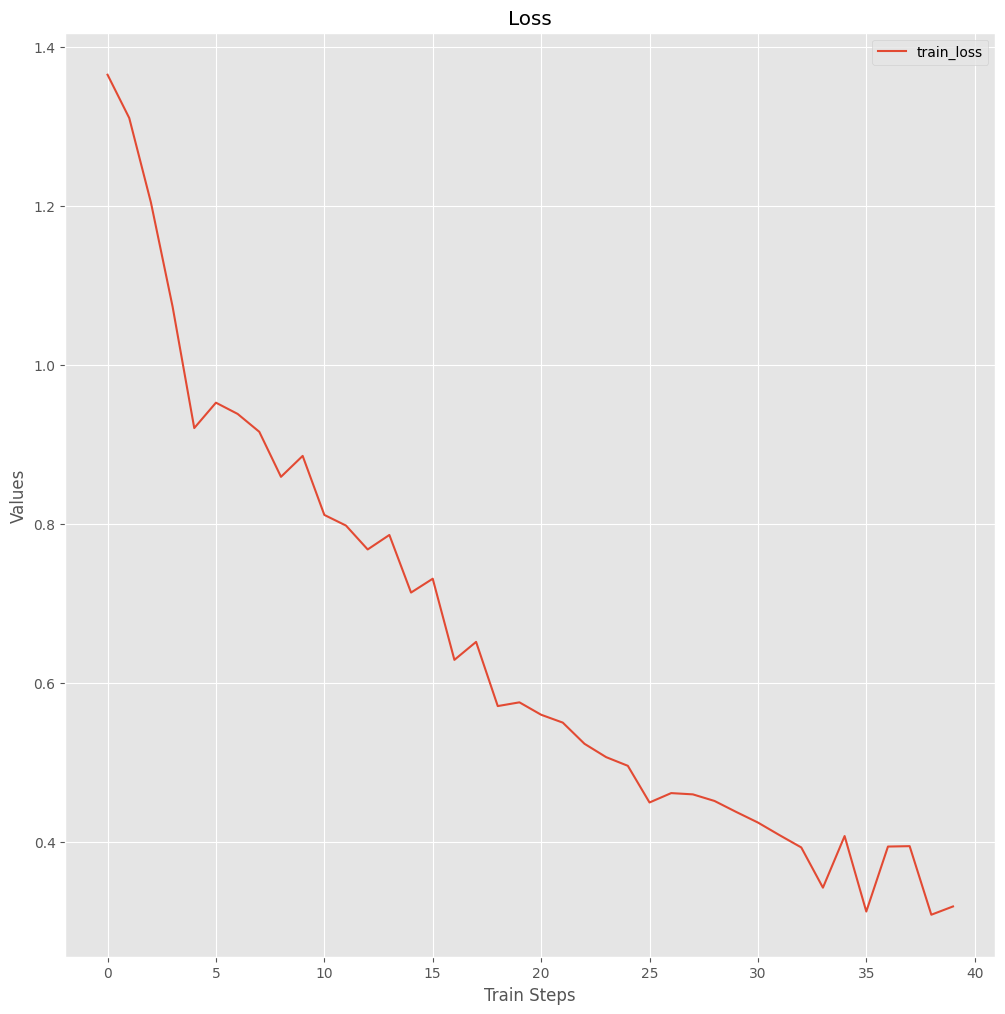

In [52]:
# Keep track of train and evaluate loss.
# loss_history = {'train_loss':[], 'eval_loss':[]}
loss_history = {'train_loss':[]}

# Keep track of train and evaluate accuracy
acc_history = {'train_acc':[], 'eval_acc':[]}

# Loop through each log history.
for log_history in trainer.state.log_history:

  if 'loss' in log_history.keys():
    # Deal with training/eval loss.
    loss_history['train_loss'].append(log_history['loss'])
    # loss_history['eval_loss'].append(log_history['eval_loss'])
    
  elif 'acc' in log_history.keys():
    # Deal with training/eval accuracy.
    loss_history['train_acc'].append(log_history['acc'])
    loss_history['eval_acc'].append(log_history['eval_acc'])

# Plot Losses.
plot_dict(loss_history, start_step=training_args.logging_steps, 
          step_size=training_args.logging_steps, use_title='Loss', 
          use_xlabel='Train Steps', use_ylabel='Values')

In [53]:
eval_history

{'eval_loss': 0.6767183542251587,
 'eval_accuracy': 0.7775,
 'eval_runtime': 1.7248,
 'eval_samples_per_second': 231.918,
 'eval_steps_per_second': 14.495,
 'epoch': 8.0}